In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Check GPU
!nvidia-smi

# Install YOLOv8 (Ultralytics)
!pip install -q ultralytics roboflow

from ultralytics import YOLO
import os, zipfile, yaml
from pathlib import Path
from IPython.display import Image, display

print("Setup complete.")


Tue Dec  2 01:15:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
DATA_ZIP = "/content/drive/MyDrive/waterlevel_yolov8.zip"

assert os.path.exists(DATA_ZIP), "Upload your dataset ZIP to /content first."

with zipfile.ZipFile(DATA_ZIP, 'r') as z:
    z.extractall("/content/waterlevel_data")

DATA_ROOT = Path("/content/waterlevel_data")
list(DATA_ROOT.iterdir())

[PosixPath('/content/waterlevel_data/README.dataset.txt'),
 PosixPath('/content/waterlevel_data/test'),
 PosixPath('/content/waterlevel_data/valid'),
 PosixPath('/content/waterlevel_data/data.yaml'),
 PosixPath('/content/waterlevel_data/train'),
 PosixPath('/content/waterlevel_data/README.roboflow.txt')]

In [ ]:
# Find data.yaml inside DATA_ROOT
DATA_YAML = next(DATA_ROOT.rglob("data.yaml"))
print("data.yaml:", DATA_YAML)

with open(DATA_YAML, "r") as f:
    data_cfg = yaml.safe_load(f)

data_cfg

data.yaml: /content/waterlevel_data/data.yaml


{'train': '../train/images',
 'val': '../valid/images',
 'test': '../test/images',
 'nc': 12,
 'names': ['0.2',
  '0.3',
  '0.4',
  '1',
  '1.1',
  '1.2',
  '1.3',
  '1.5',
  '2.1',
  '2.3',
  'Water Level',
  'staff gauge'],
 'roboflow': {'workspace': 'watersegmentation-zsbtl',
  'project': 'my-first-project-q9p6z',
  'version': 1,
  'license': 'CC BY 4.0',
  'url': 'https://universe.roboflow.com/watersegmentation-zsbtl/my-first-project-q9p6z/dataset/1'}}

In [ ]:
# Path to the extracted dataset folder
DATA_ROOT = Path("/content/waterlevel_data")   # <-- change if your folder name is different

DATA_YAML = DATA_ROOT / "data.yaml"

# Load yaml
with open(DATA_YAML, "r") as f:
    data_cfg = yaml.safe_load(f)

# Fix paths (overwrite relative paths with absolute ones)
data_cfg["train"] = str(DATA_ROOT / "train" / "images")
data_cfg["val"]   = str(DATA_ROOT / "valid" / "images")
data_cfg["test"]  = str(DATA_ROOT / "test" / "images")

# Save updated yaml
with open(DATA_YAML, "w") as f:
    yaml.dump(data_cfg, f)

print("✔ data.yaml fixed and saved!\n")
print(data_cfg)


✔ data.yaml fixed and saved!

{'train': '/content/waterlevel_data/train/images', 'val': '/content/waterlevel_data/valid/images', 'test': '/content/waterlevel_data/test/images', 'nc': 12, 'names': ['0.2', '0.3', '0.4', '1', '1.1', '1.2', '1.3', '1.5', '2.1', '2.3', 'Water Level', 'staff gauge'], 'roboflow': {'workspace': 'watersegmentation-zsbtl', 'project': 'my-first-project-q9p6z', 'version': 1, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/watersegmentation-zsbtl/my-first-project-q9p6z/dataset/1'}}


In [ ]:
root = DATA_YAML.parent
train_images = root / data_cfg["train"]
val_images   = root / data_cfg["val"]

print("Root:", root)
print("Train images exist?", train_images.exists())
print("Val images exist?  ", val_images.exists())
print("Sample train images:")
for i, name in enumerate(os.listdir(train_images)):
    print(" ", name)
    if i >= 4:
        break


Root: /content/waterlevel_data
Train images exist? True
Val images exist?   True
Sample train images:
  IMG_4084_JPG.rf.3c4e6f39e2ab973a6ba7245411f7947b.jpg
  IMG_4107_JPG.rf.458d73d89f323e85e1b6fb4e219fe259.jpg
  IMG_4123_JPG.rf.8aa943ca6065dd5c96055ebc245ca5aa.jpg
  IMG_4034_JPG.rf.2aa60f9769922473ce041842d24f53c2.jpg
  IMG_4170_JPG.rf.574c472e8c93804cfbabe61465315c51.jpg


In [ ]:
from ultralytics import YOLO

# Load pretrained YOLOv8-Large model
model_l = YOLO("yolov8l.pt")

results_l = model_l.train(
    data=str(DATA_YAML),          # path to data.yaml
    epochs=200,                   # you can lower to 100 if needed
    imgsz=640,                    # good for your small gauge numbers
    batch=16,                     # adjust if you get CUDA OOM (try 8 or 4)
    patience=80,                  # early stopping
    project="runs_waterlevel",    # folder for all runs
    name="yolov8l_waterlevel",    # experiment name
    device=0                      # use GPU 0
)

results_l


Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/waterlevel_data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8l_waterlevel, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=80, perspective=0.0, pl

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  3,  4,  5,  6, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7883f20f1e80>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0

In [ ]:
exp_dir_l = Path("runs_waterlevel") / "yolov8l_waterlevel"
best_weights_l = exp_dir_l / "weights" / "best.pt"

print("Best weights:", best_weights_l)
assert best_weights_l.exists(), "best.pt not found!"

model_l = YOLO(str(best_weights_l))

val_metrics_l = model_l.val(
    data=str(DATA_YAML),
    split="val"   # evaluate on validation set
)

val_metrics_l


Best weights: runs_waterlevel/yolov8l_waterlevel/weights/best.pt
Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,615,860 parameters, 0 gradients, 164.9 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1587.5±807.5 MB/s, size: 74.5 KB)
val: Scanning /content/waterlevel_data/valid/labels.cache... 24 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 24/24 30.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.3it/s 1.5s
                   all         24         72      0.639      0.823       0.81      0.465
                   0.2          5          5      0.501          1      0.898      0.353
                   0.3          5          5       0.84          1      0.995      0.516
                     1          7          7      0.592          1      0.995      0.402
                   1.1          3          3      0.719      0.875

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  3,  4,  5,  6, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7883f34bc950>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0

BoxF1_curve.png


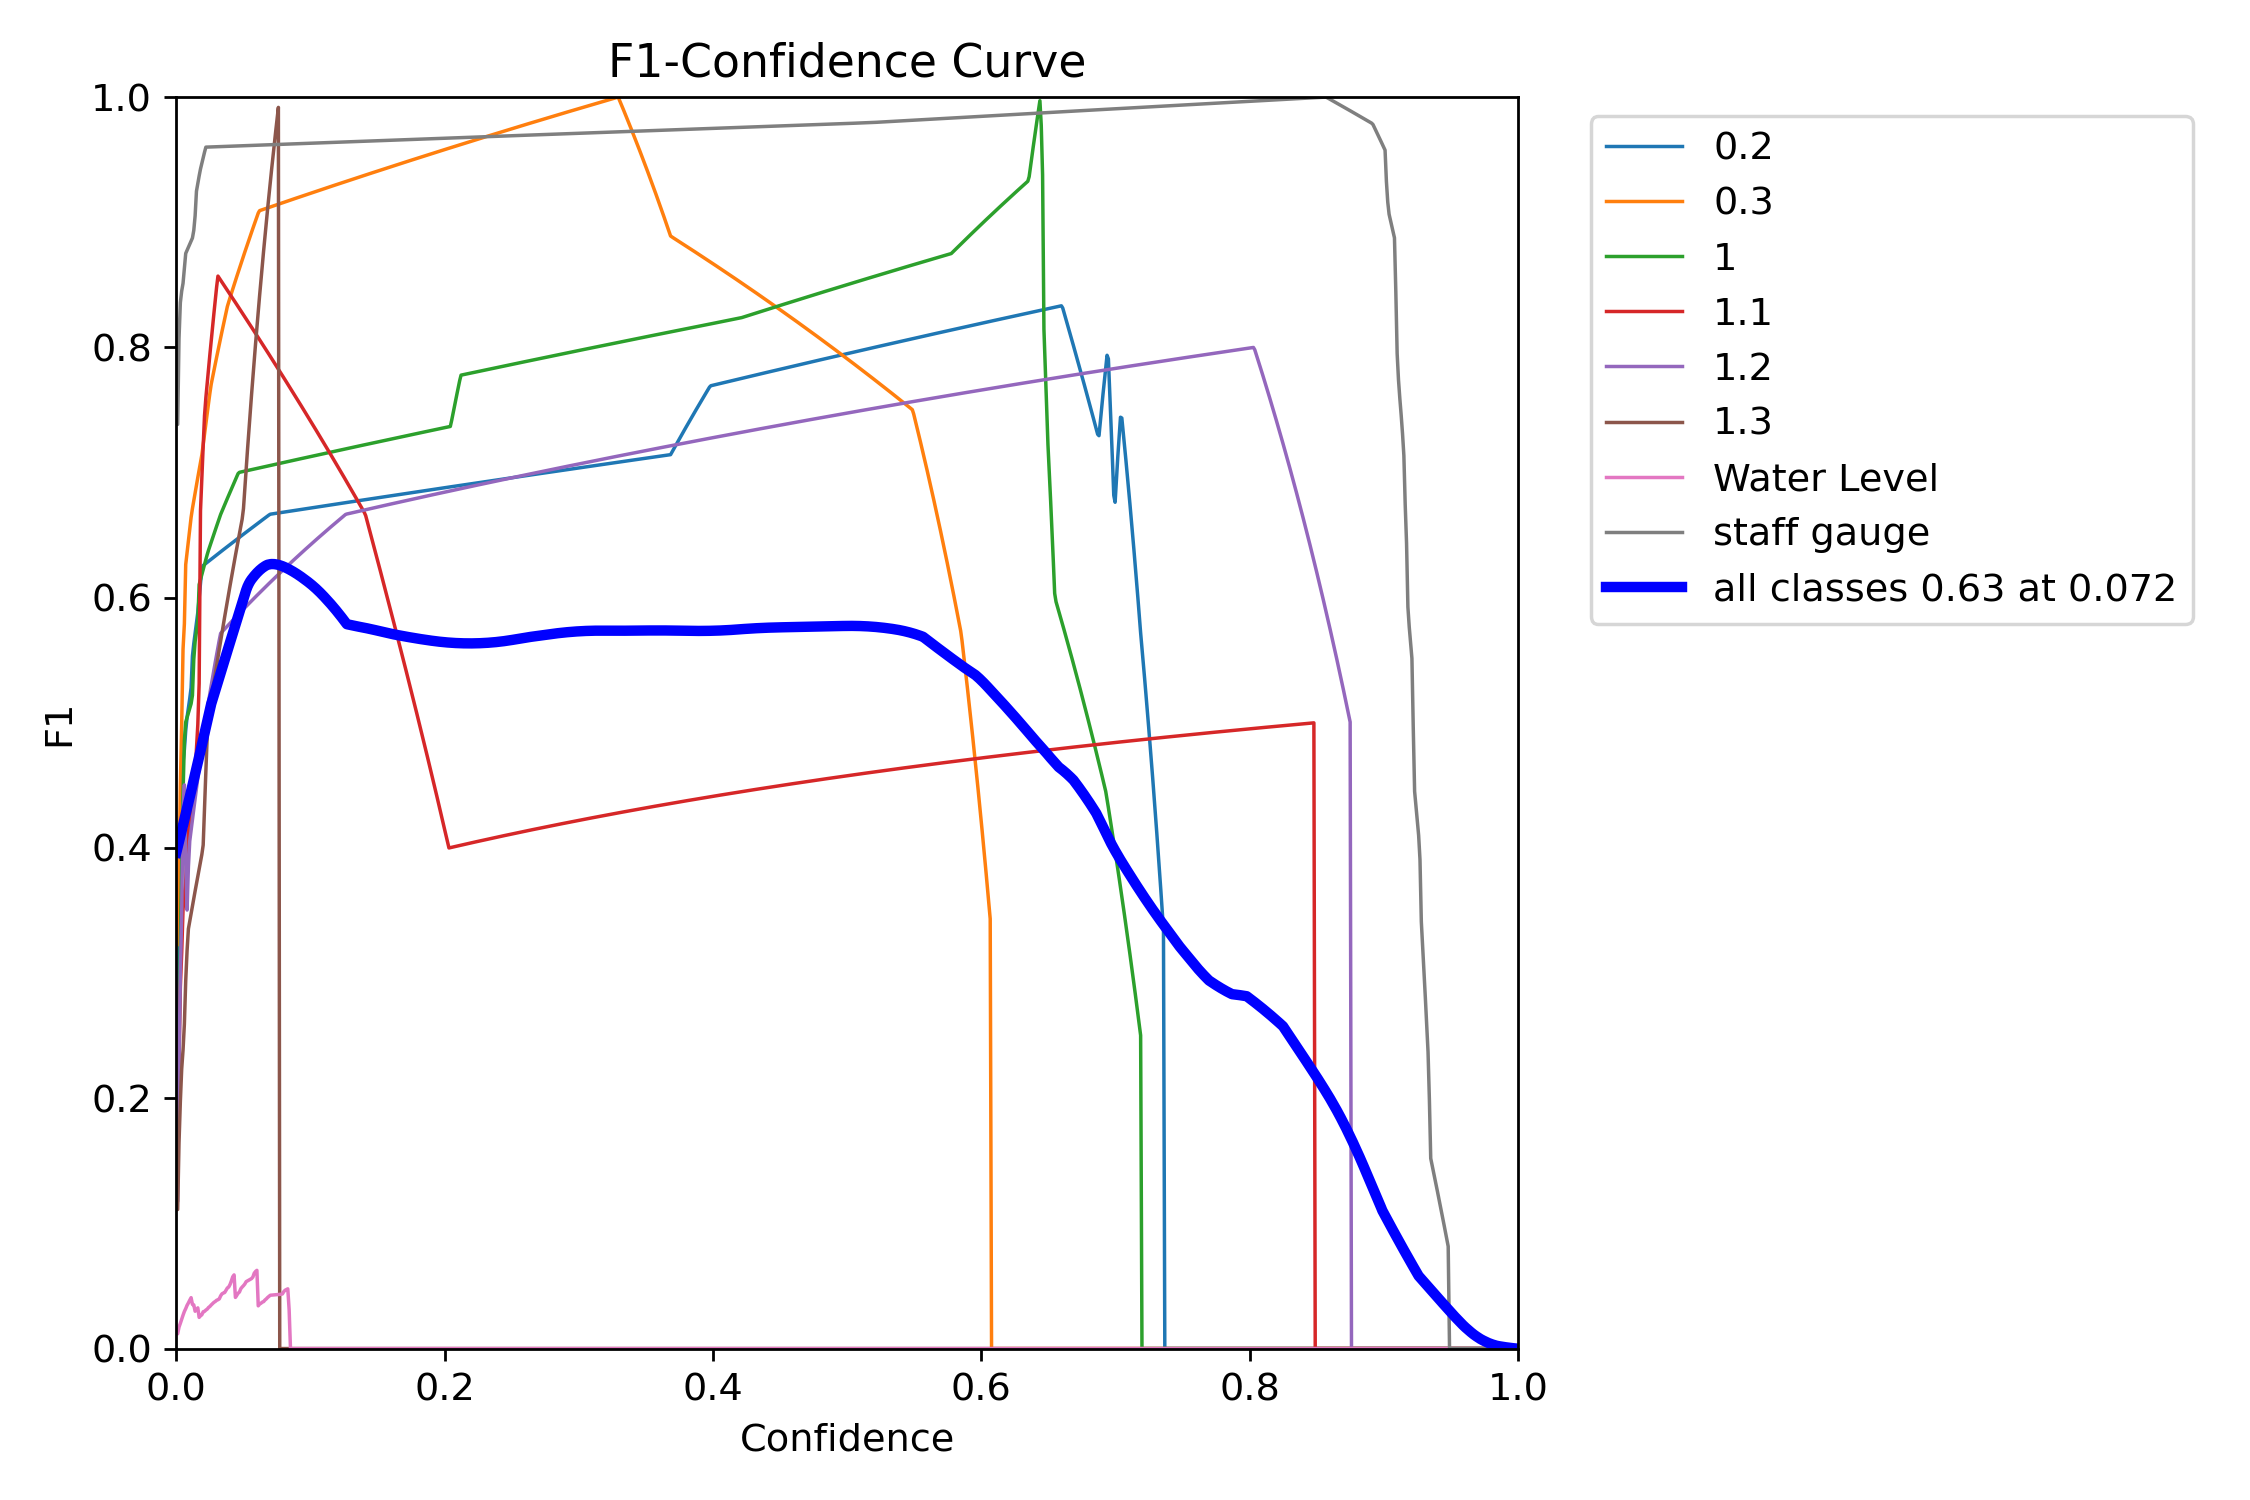

BoxR_curve.png


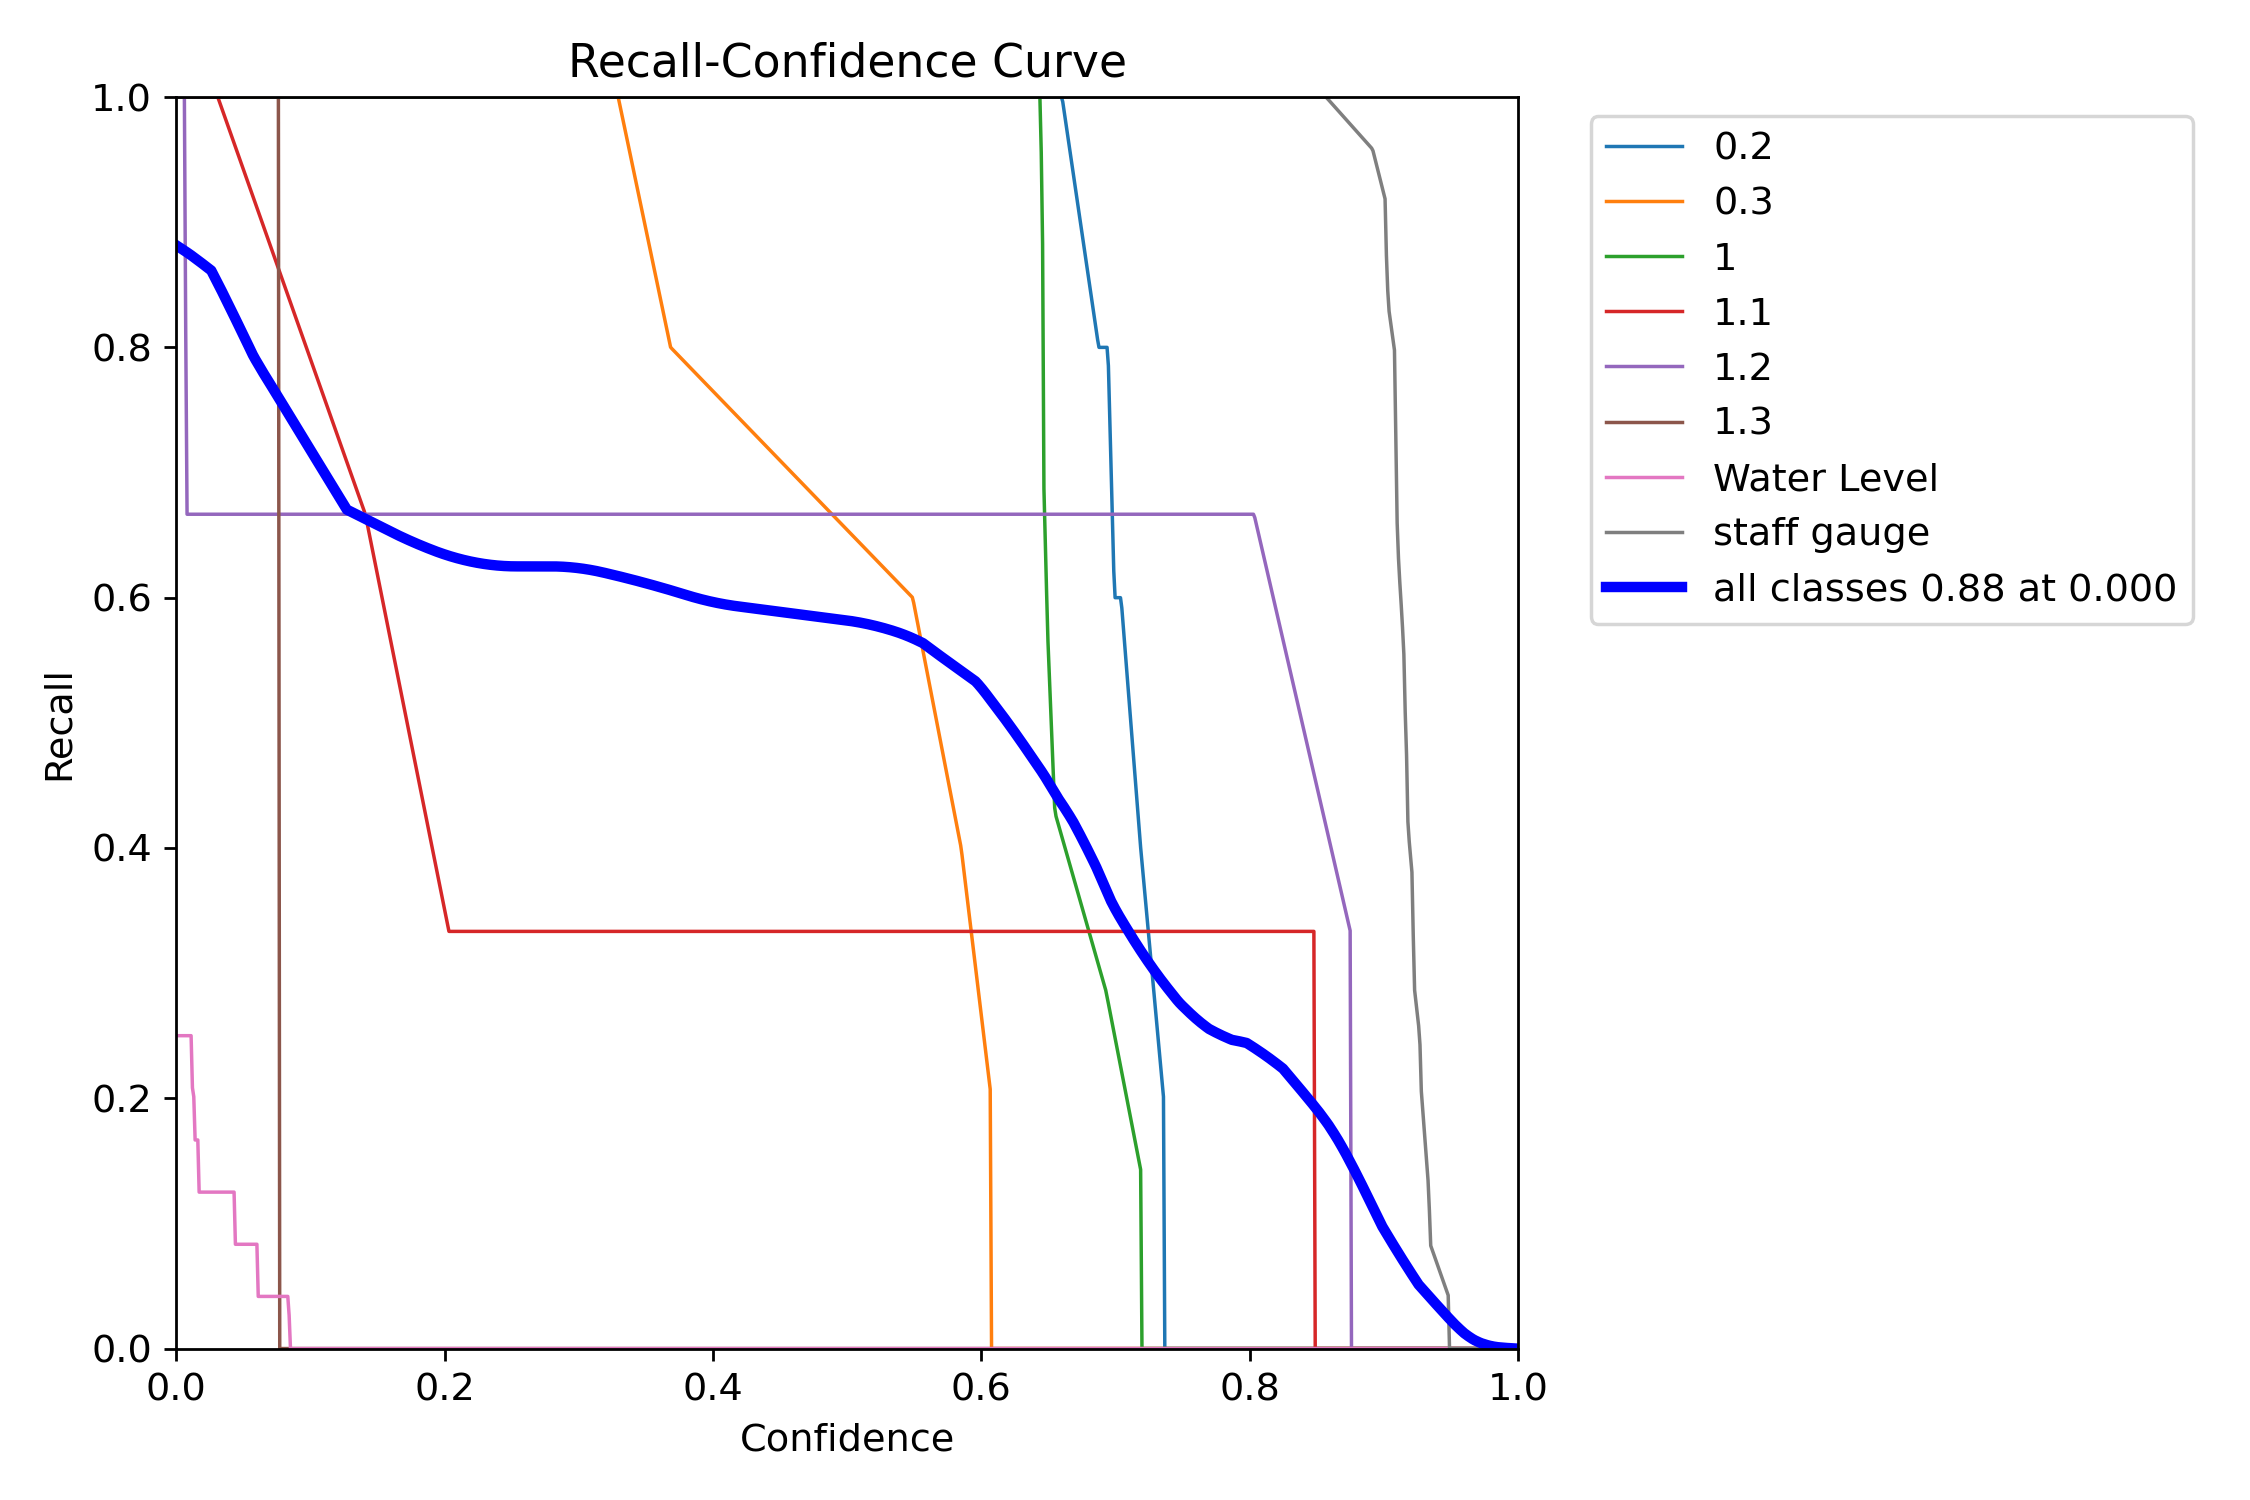

confusion_matrix.png


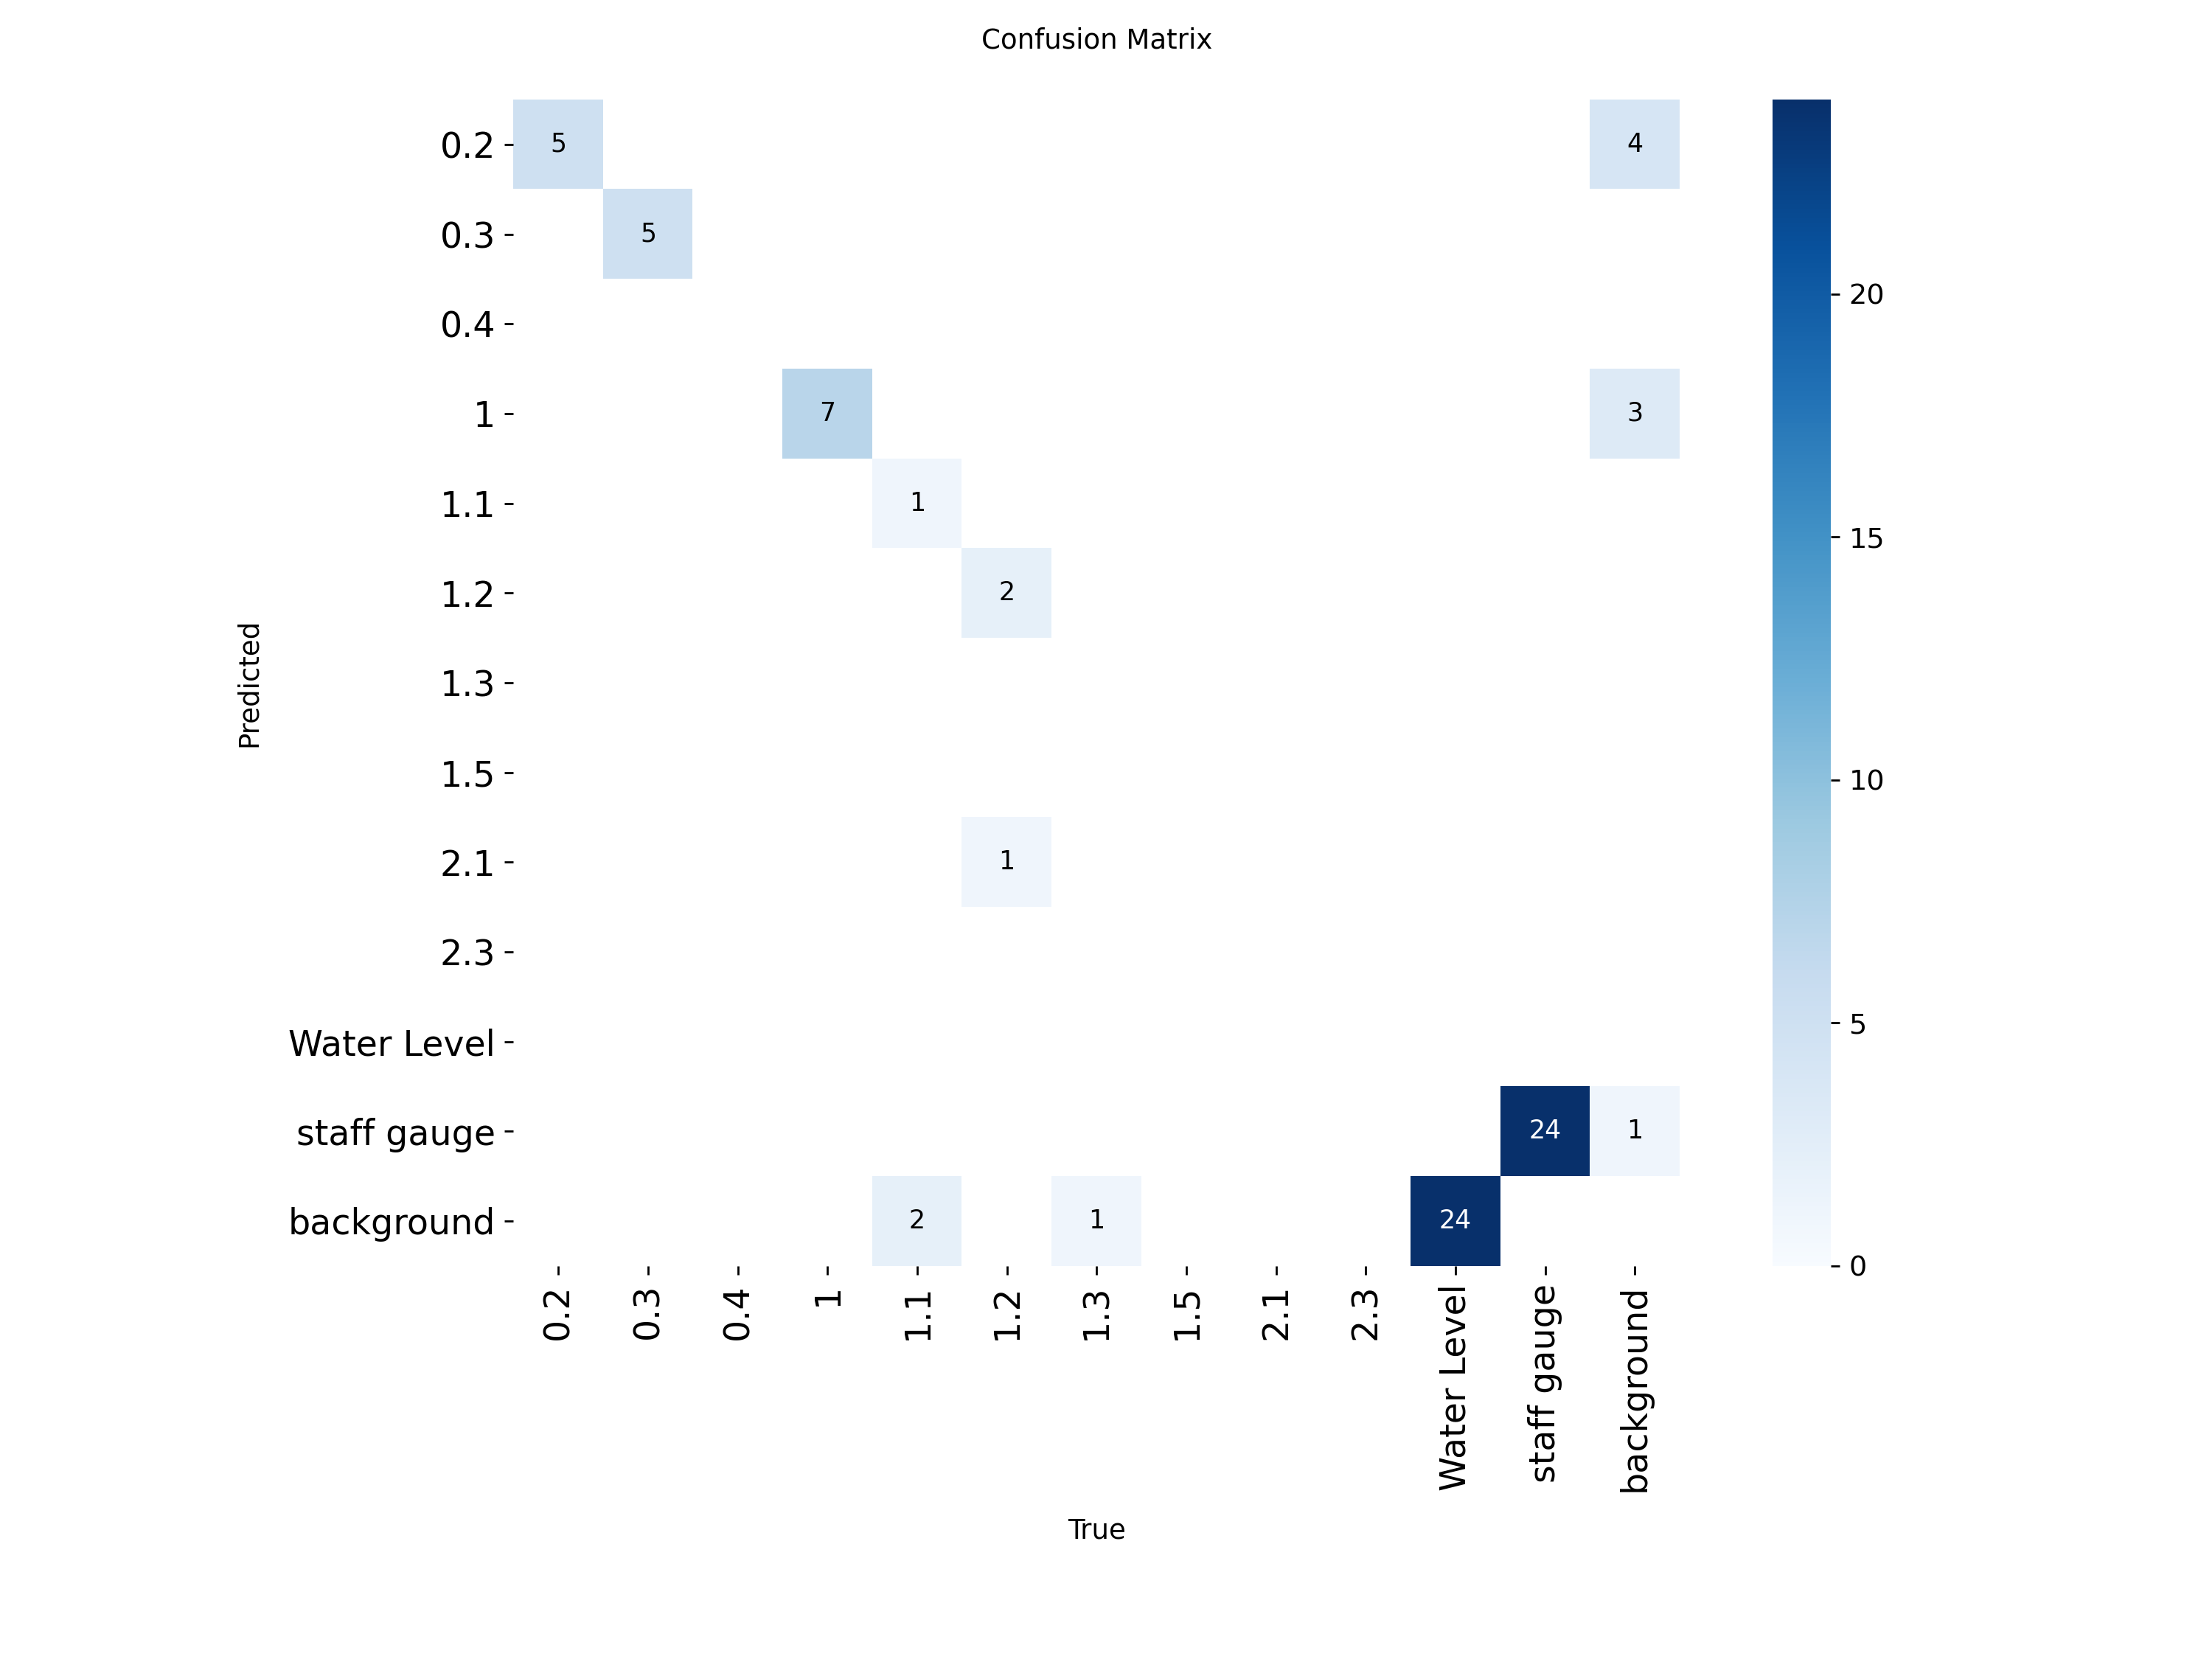

results.png


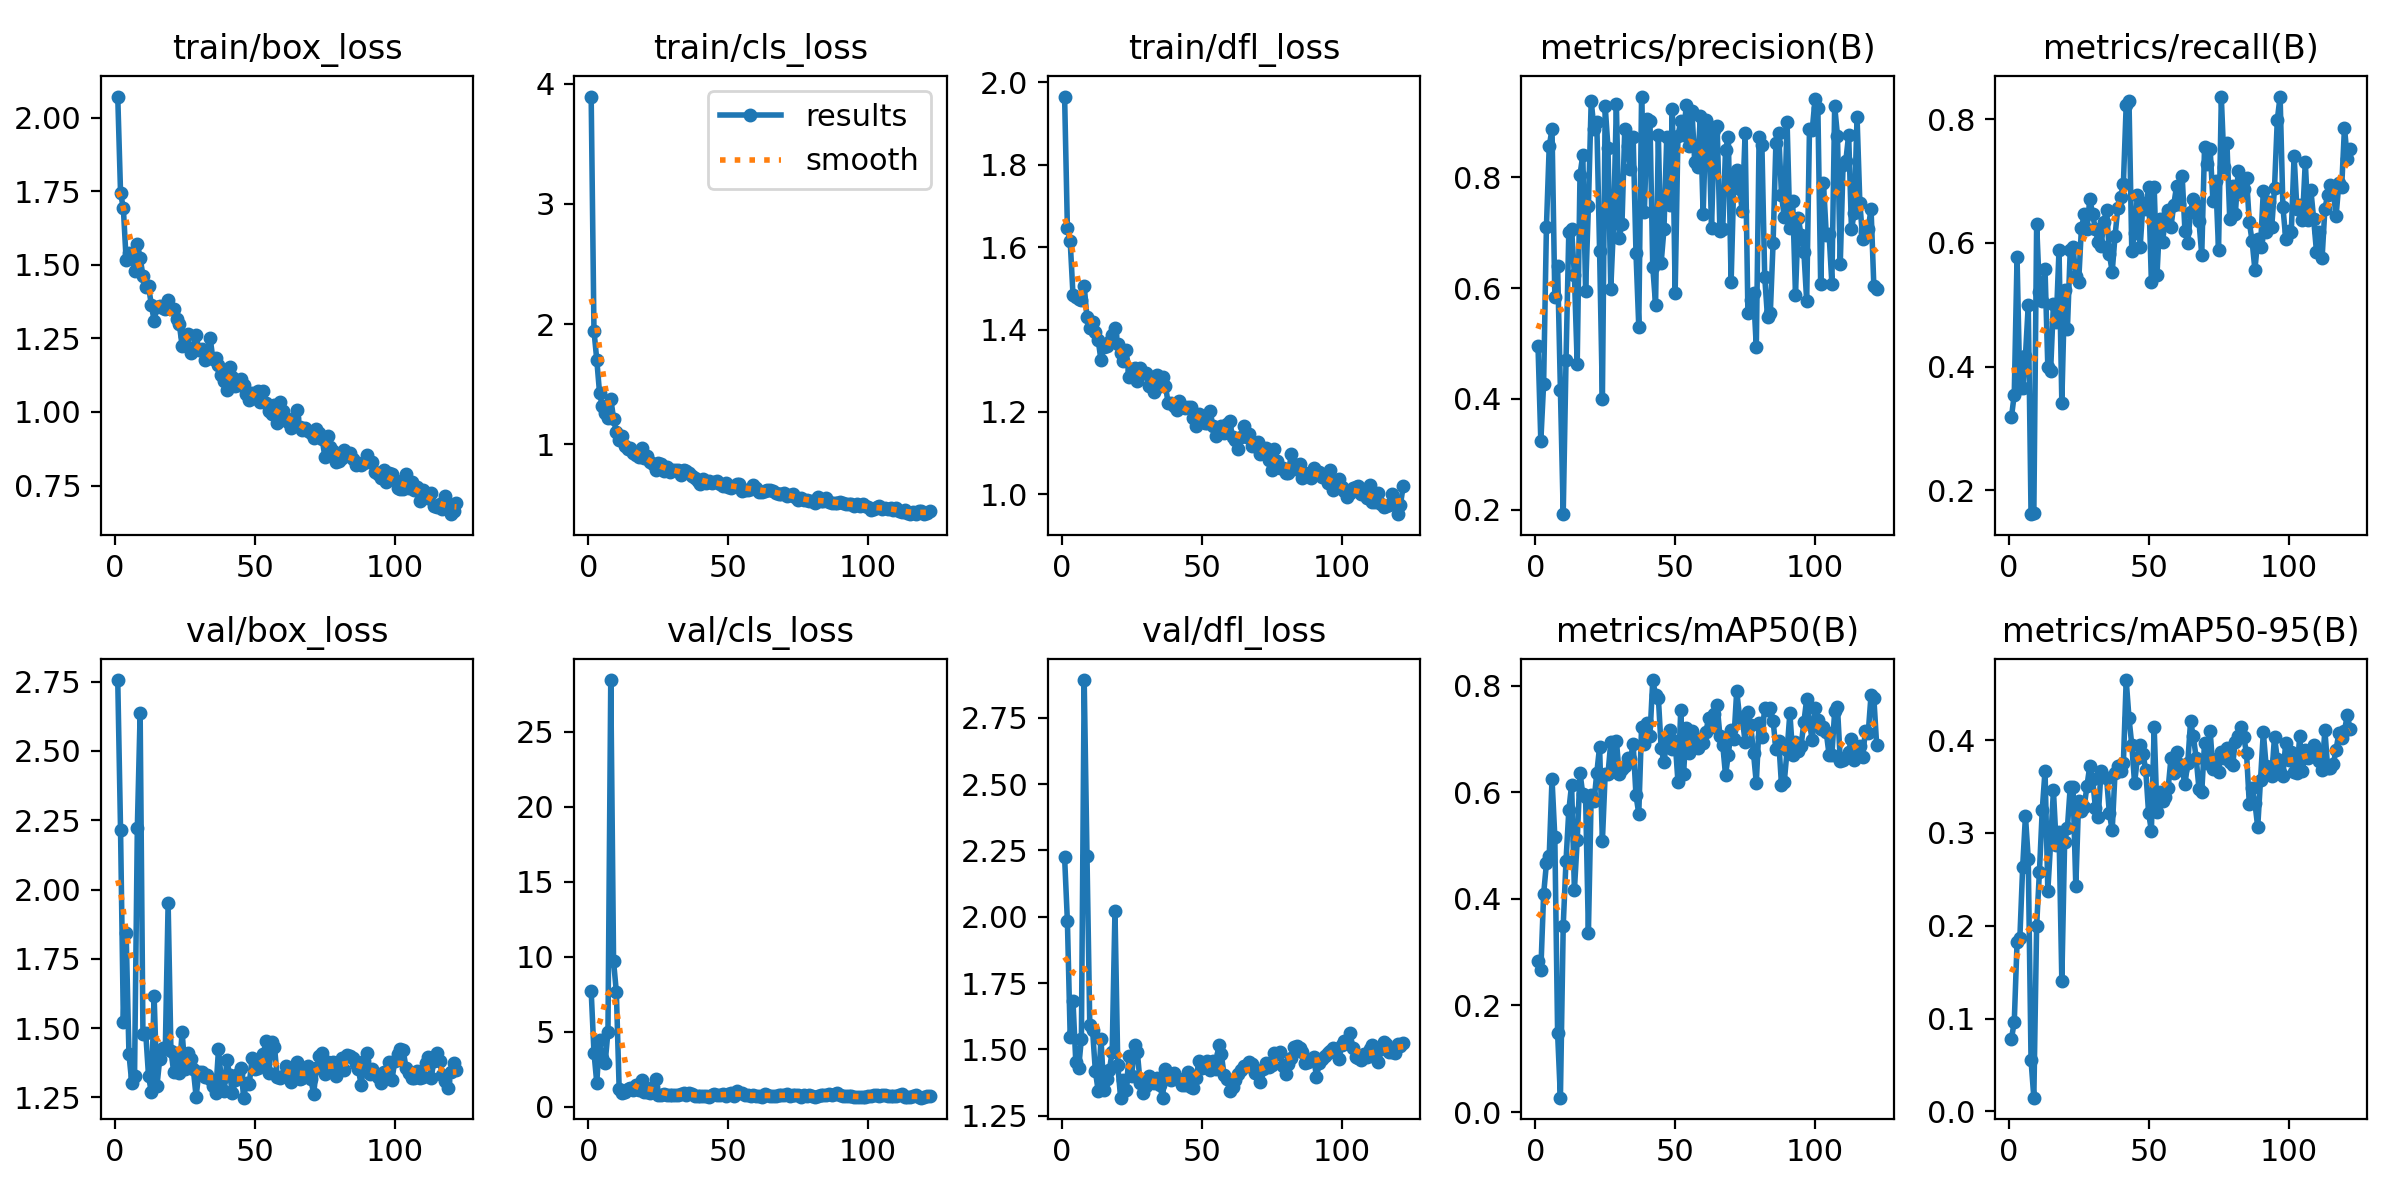

confusion_matrix_normalized.png


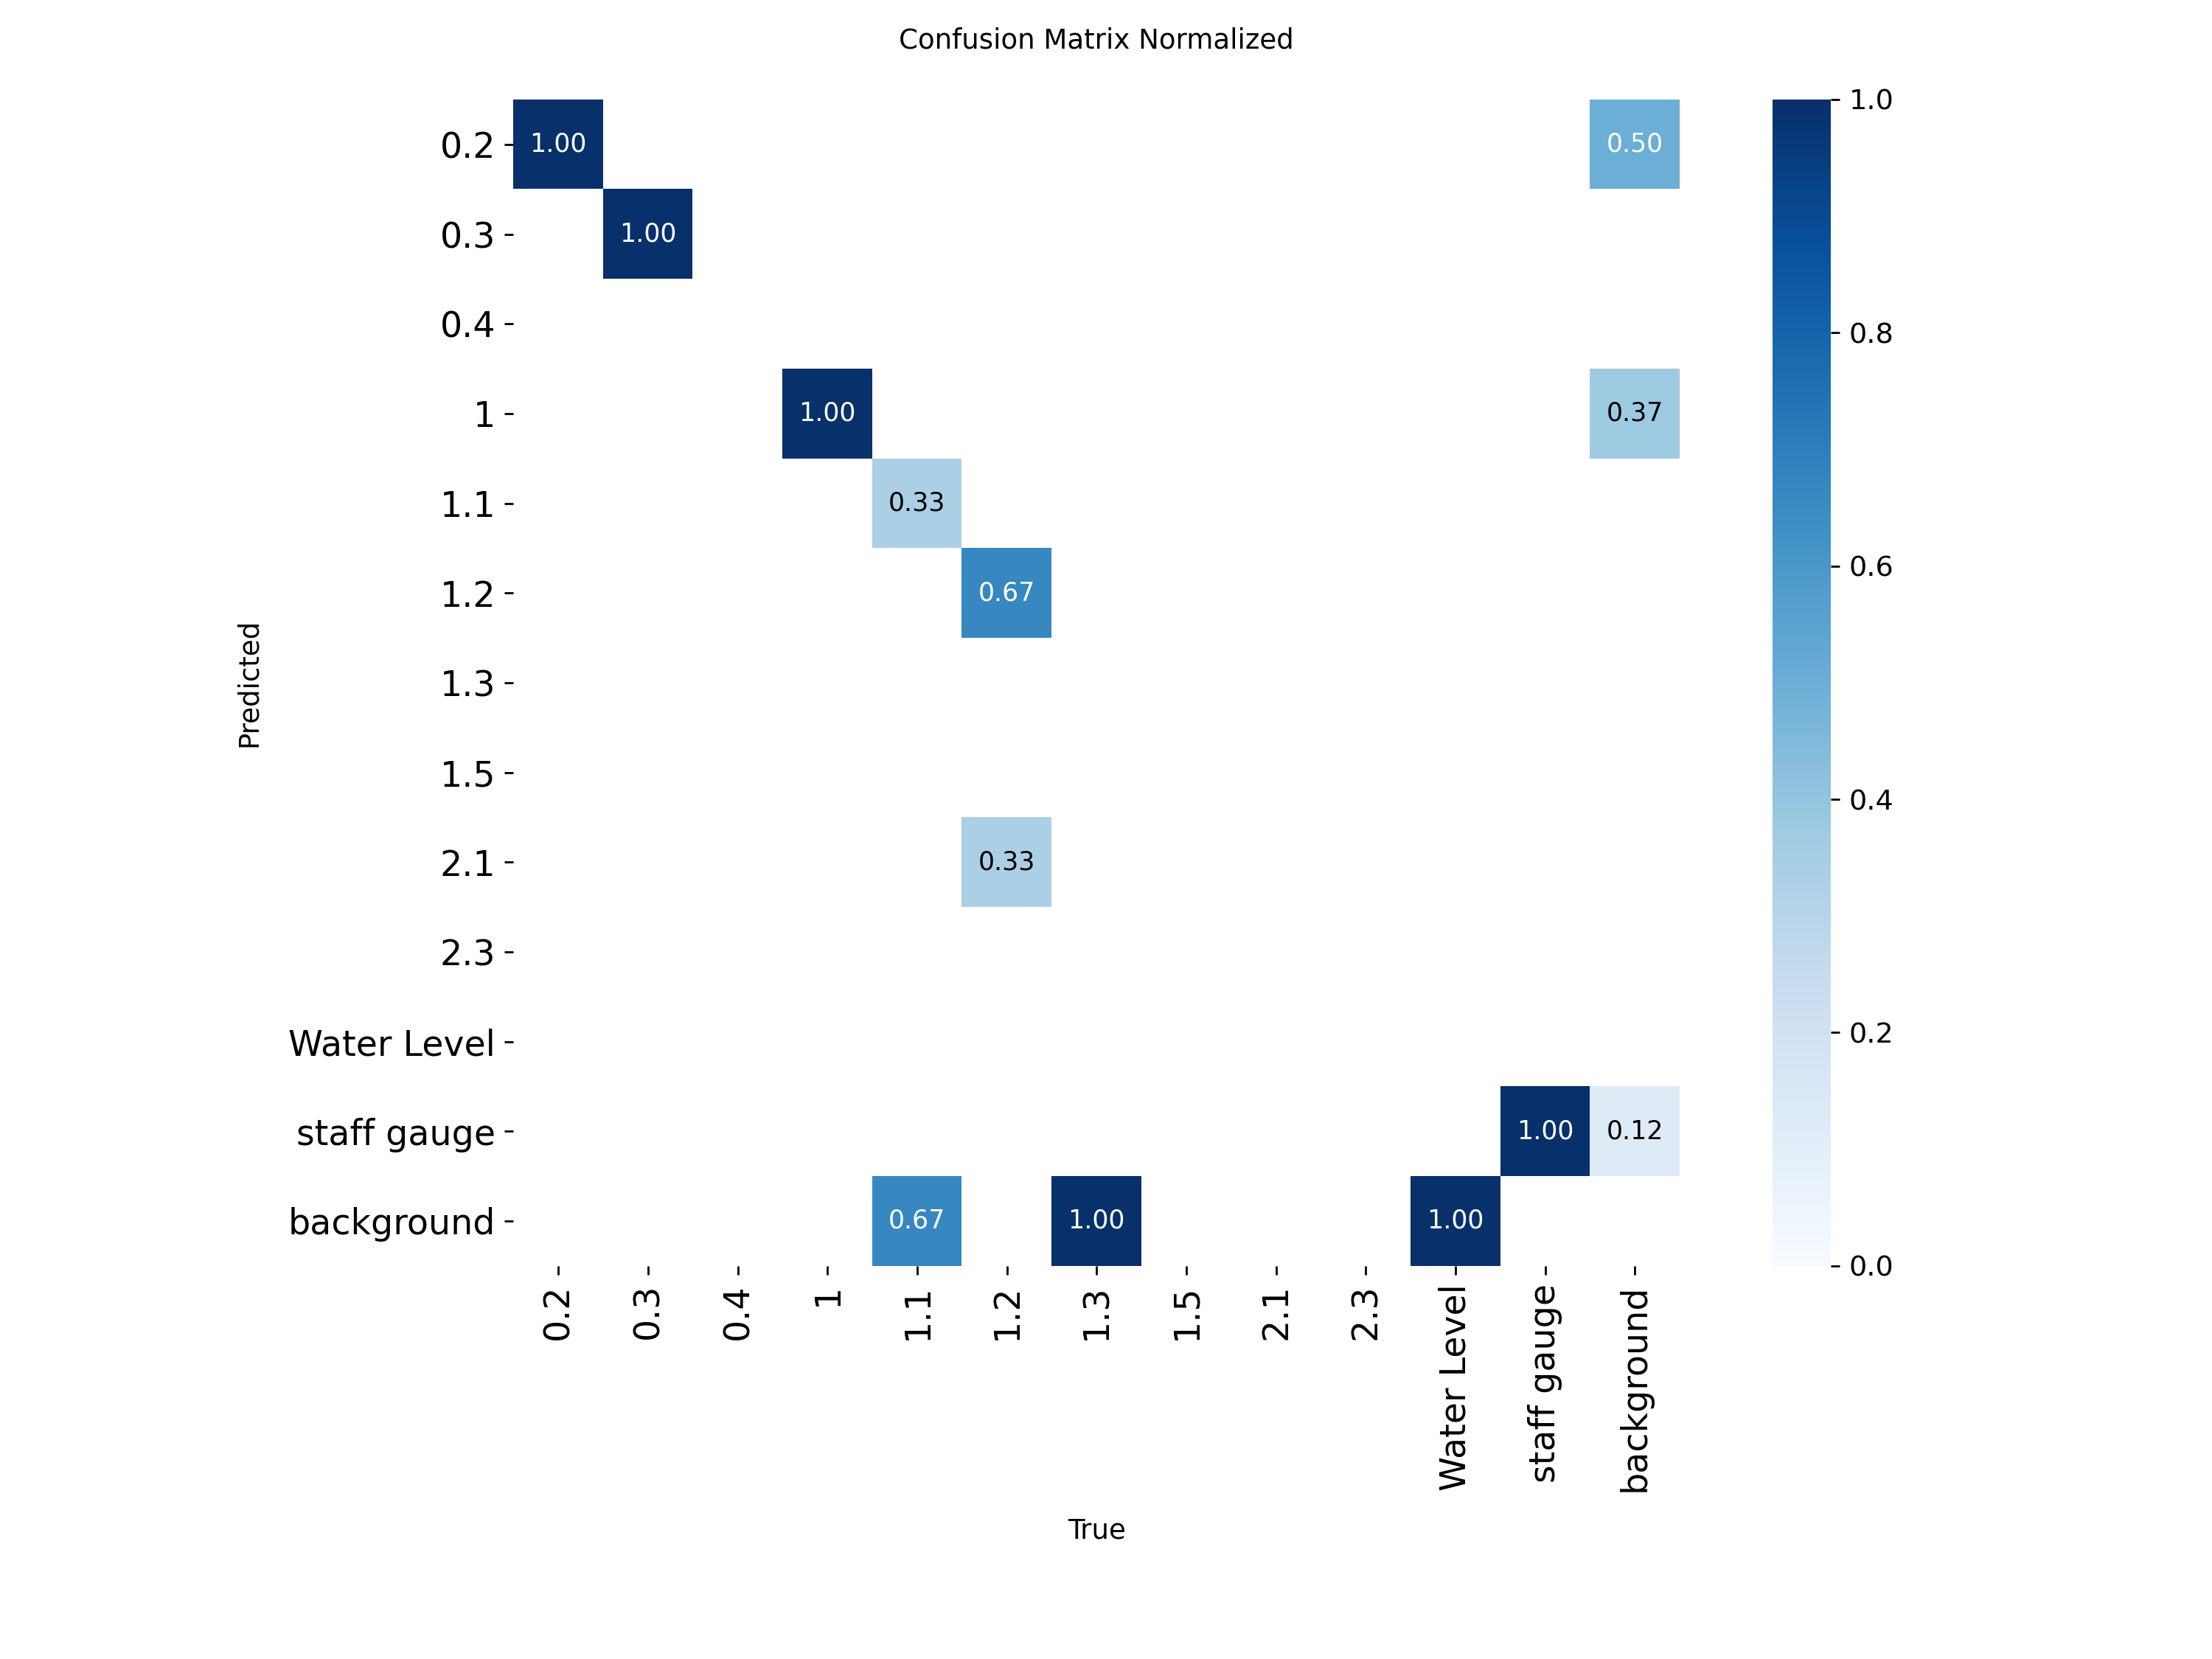

BoxP_curve.png


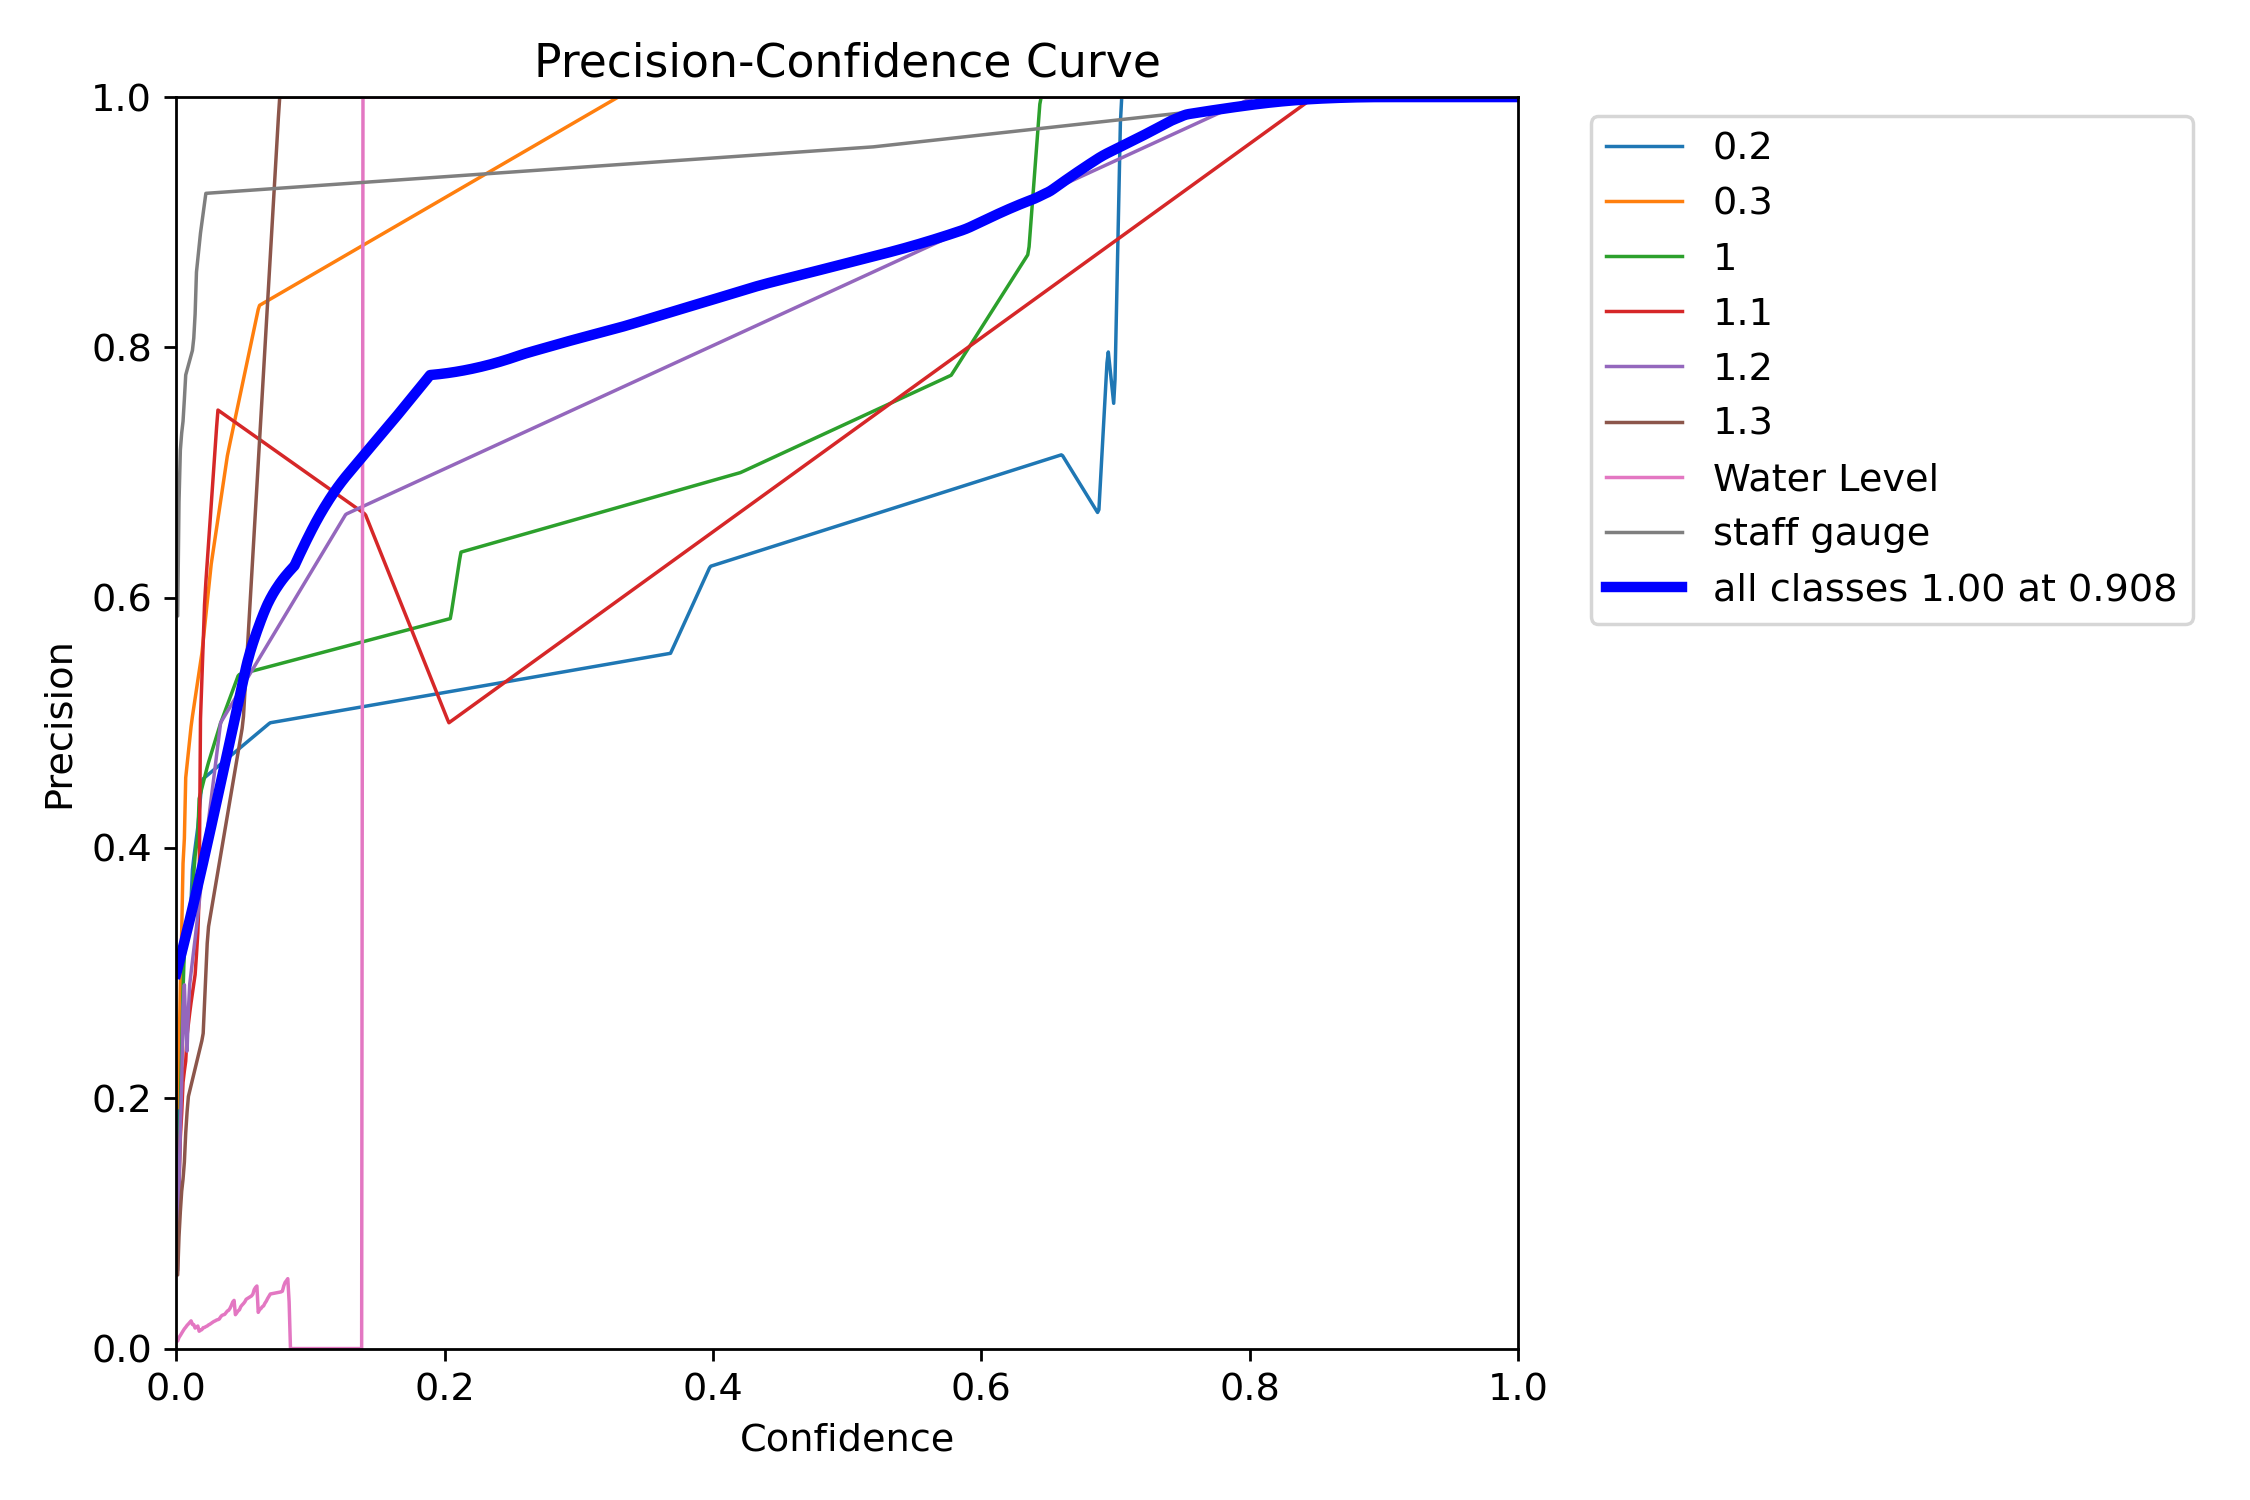

BoxPR_curve.png


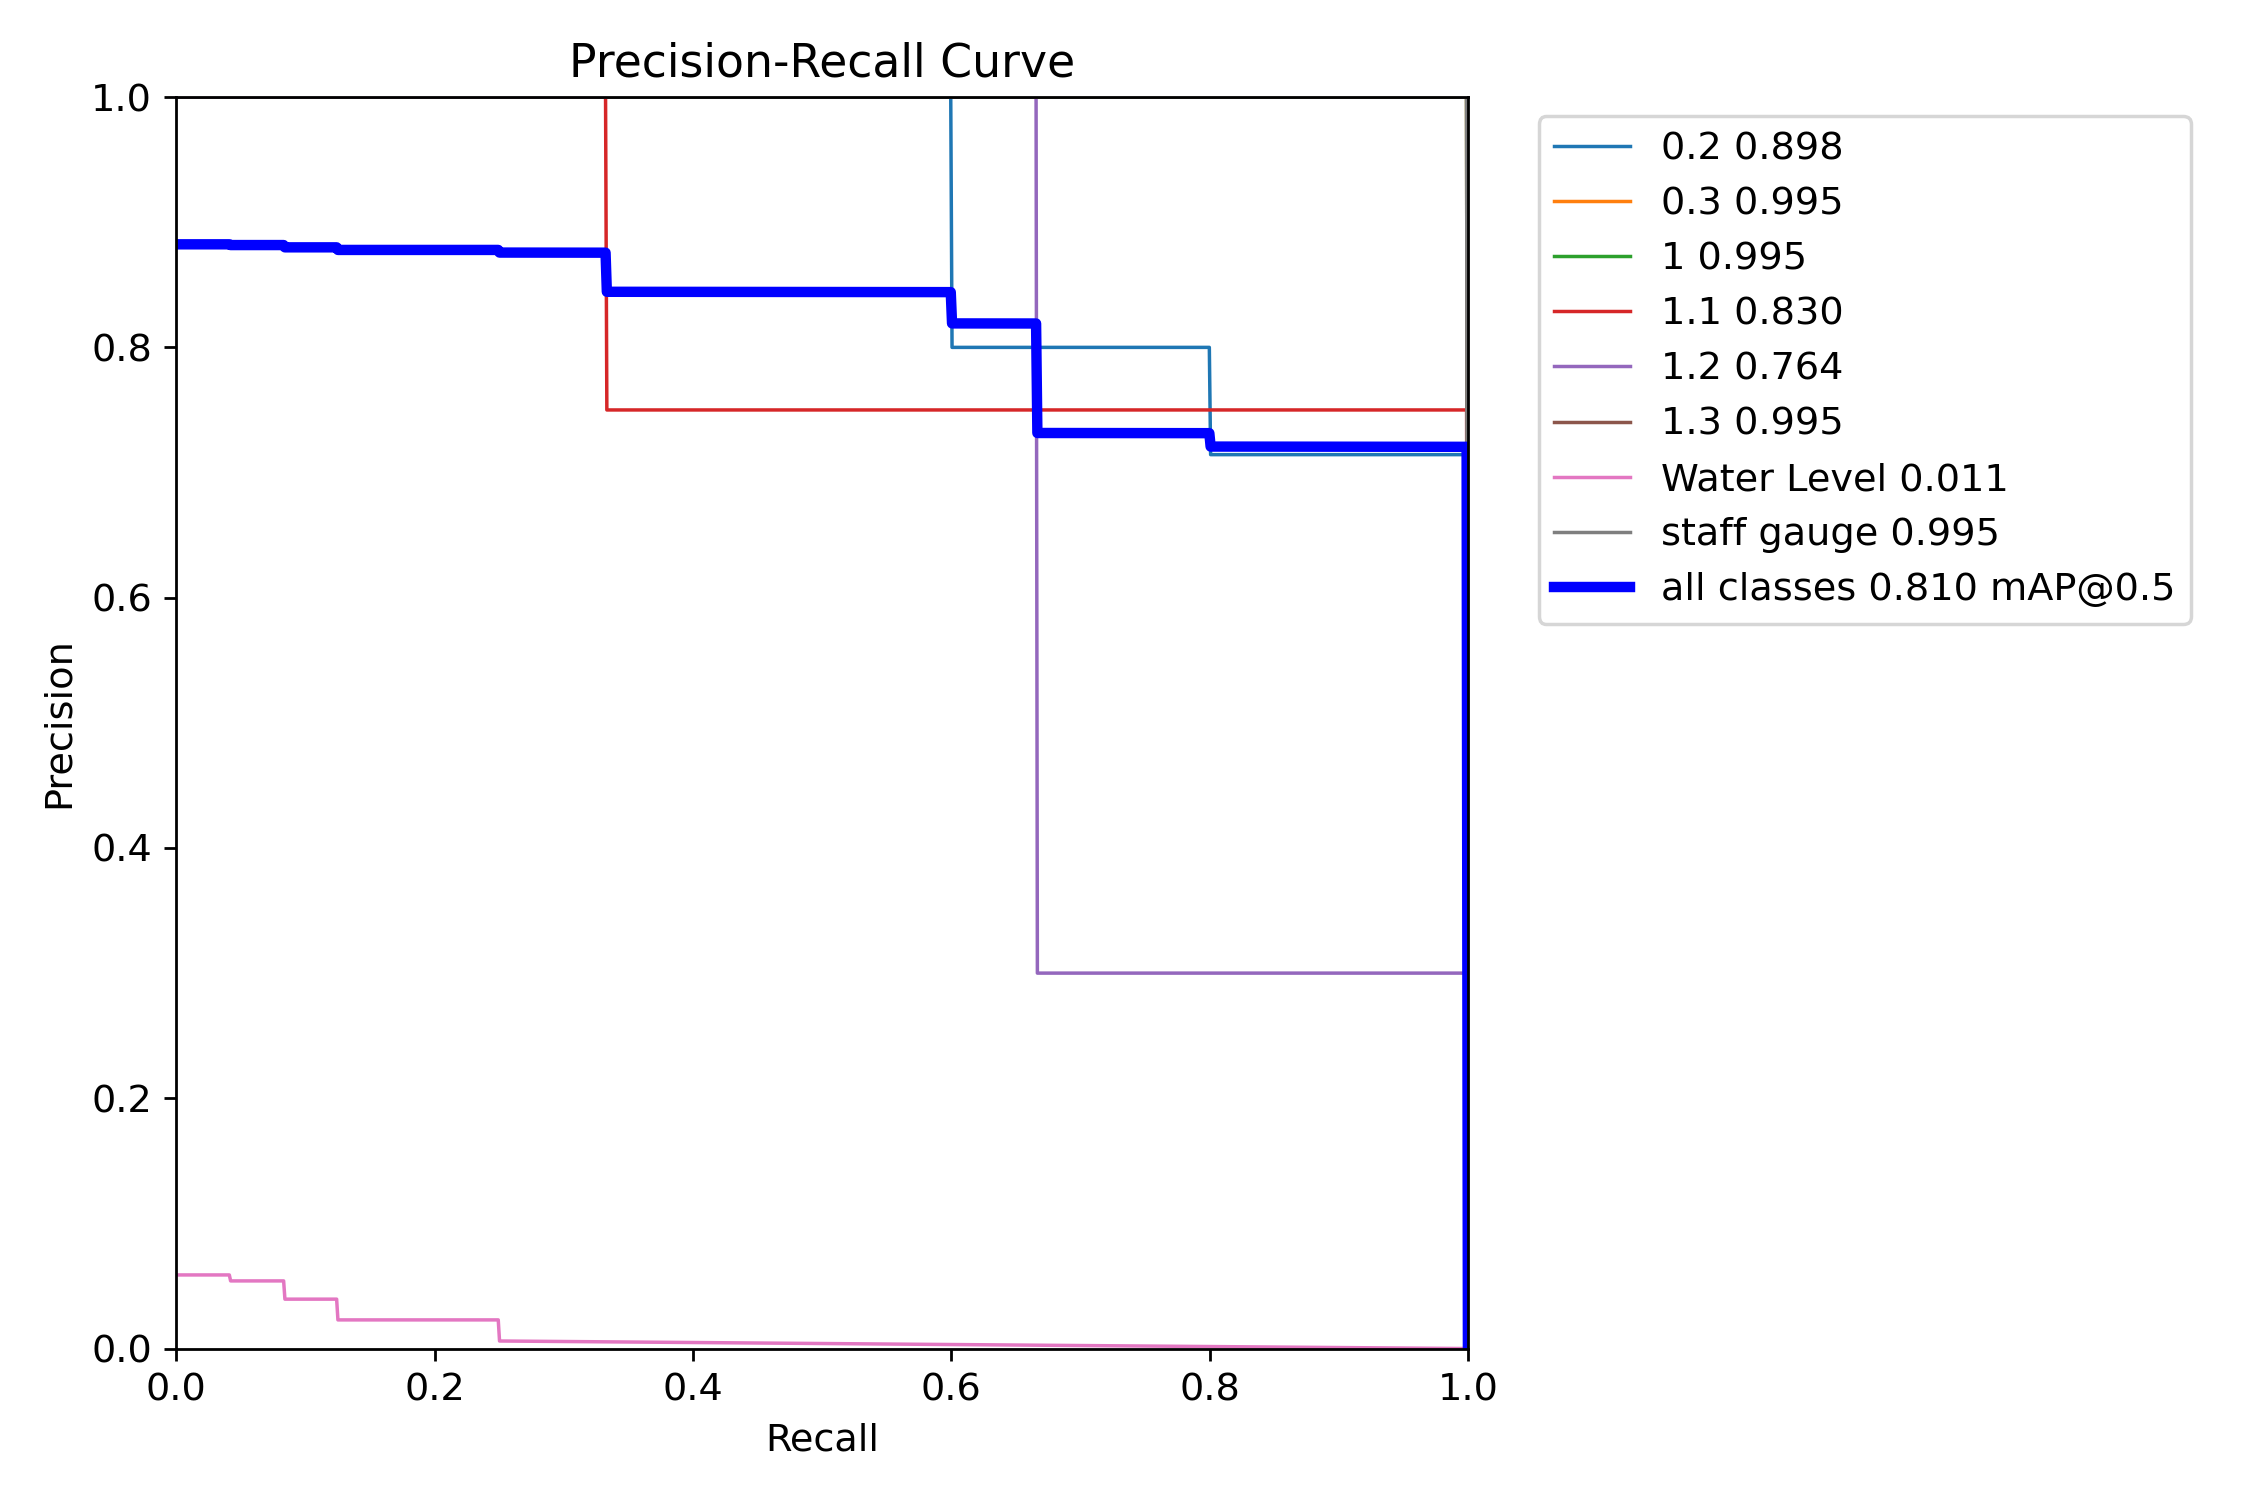

In [ ]:
for fname in os.listdir(exp_dir_l):
    if fname.endswith(".png"):
        print(fname)
        display(Image(filename=str(exp_dir_l / fname), width=400))   # <<< smaller

In [ ]:
test_metrics_l = model_l.val(
    data=str(DATA_YAML),
    split="test"
)

test_metrics_l


Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 35.9±12.5 MB/s, size: 63.5 KB)
val: Scanning /content/waterlevel_data/test/labels... 24 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 24/24 793.1it/s 0.0s
val: New cache created: /content/waterlevel_data/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.4it/s 1.5s
                   all         24         72      0.765      0.672      0.729      0.325
                   0.2          3          3      0.933          1      0.995       0.16
                   0.3          3          3          1      0.941      0.995       0.31
                     1          8          8       0.71          1      0.982      0.437
                   1.1          4          4      0.568      0.353      0.845        0.5
                   1.2          4          4      0.851       0.75   

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  3,  4,  5,  6,  8, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x788598ca5400>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046, 

In [ ]:
val_folder = root / data_cfg["val"]

results = model_l.predict(
    source=str(val_folder),
    save=True,
    project="runs_waterlevel",
    name="predictions_val_yolov8l",
    conf=0.17,   # from earlier F1 curves; tweak as needed
    imgsz=640
)

print("Saved to:", Path("runs_waterlevel") / "predictions_val_yolov8l")



image 1/24 /content/waterlevel_data/valid/images/IMG_4035_JPG.rf.16e665c1e069f54edc83f2238d708e78.jpg: 640x576 1 staff gauge, 140.2ms
image 2/24 /content/waterlevel_data/valid/images/IMG_4047_JPG.rf.5d4645f06fa63d93b92bb90ff19c21bb.jpg: 640x576 2 1.1s, 1 staff gauge, 54.9ms
image 3/24 /content/waterlevel_data/valid/images/IMG_4053_JPG.rf.890d9588dc67104cf2fcb51e22fd6230.jpg: 640x576 1 2.1, 1 staff gauge, 51.9ms
image 4/24 /content/waterlevel_data/valid/images/IMG_4057_JPG.rf.50adbbb67bdbdf9caf9c1c86b1c9b785.jpg: 640x576 1 1.2, 1 staff gauge, 51.8ms
image 5/24 /content/waterlevel_data/valid/images/IMG_4065_JPG.rf.ccde114ad2da86436489909b918c5c8b.jpg: 640x576 1 1.2, 1 staff gauge, 51.8ms
image 6/24 /content/waterlevel_data/valid/images/IMG_4070_JPG.rf.ce4eac12867ad1e586784727de430830.jpg: 640x576 1 1, 1 staff gauge, 34.3ms
image 7/24 /content/waterlevel_data/valid/images/IMG_4076_JPG.rf.a71a3e9ccc102d8dd58c7a8af59ecf27.jpg: 640x576 1 1, 1 staff gauge, 33.2ms
image 8/24 /content/waterlev

IMG_4035_JPG.rf.16e665c1e069f54edc83f2238d708e78.jpg


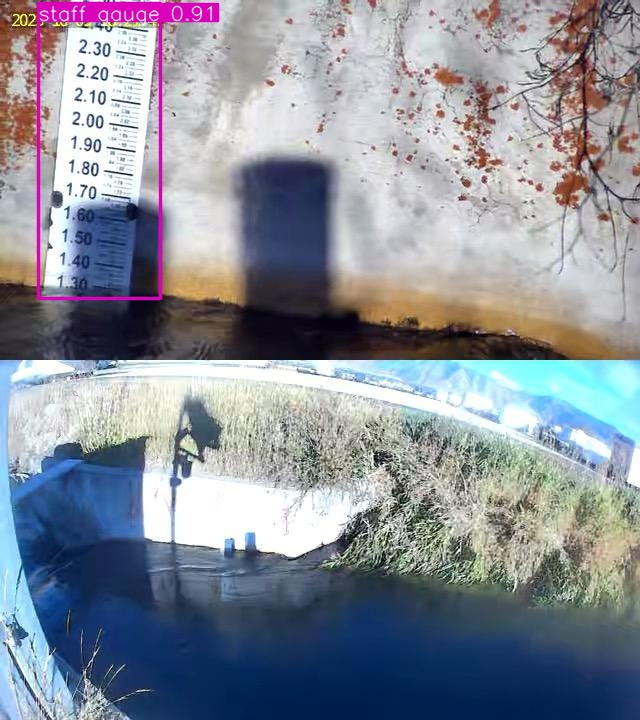

IMG_4047_JPG.rf.5d4645f06fa63d93b92bb90ff19c21bb.jpg


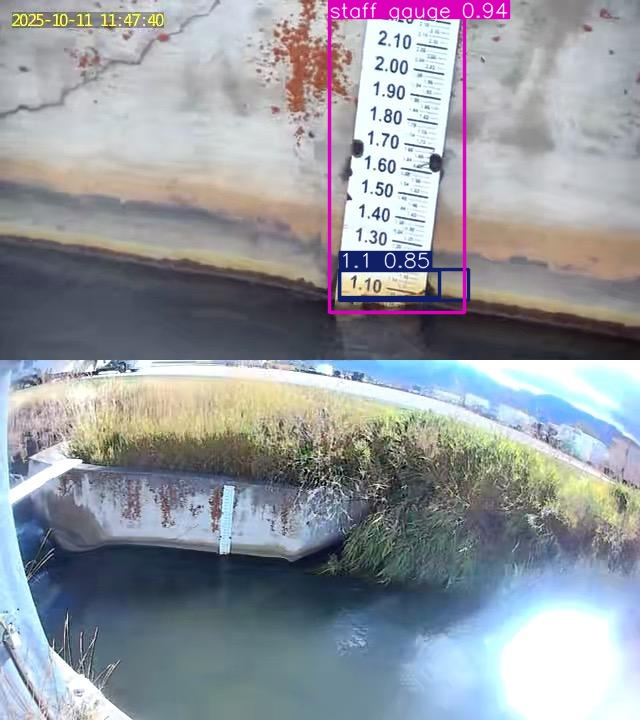

IMG_4053_JPG.rf.890d9588dc67104cf2fcb51e22fd6230.jpg


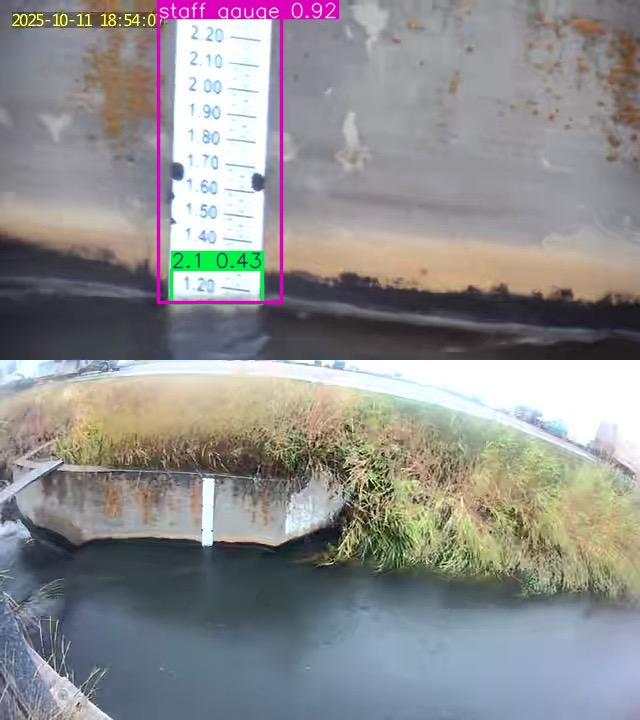

IMG_4057_JPG.rf.50adbbb67bdbdf9caf9c1c86b1c9b785.jpg


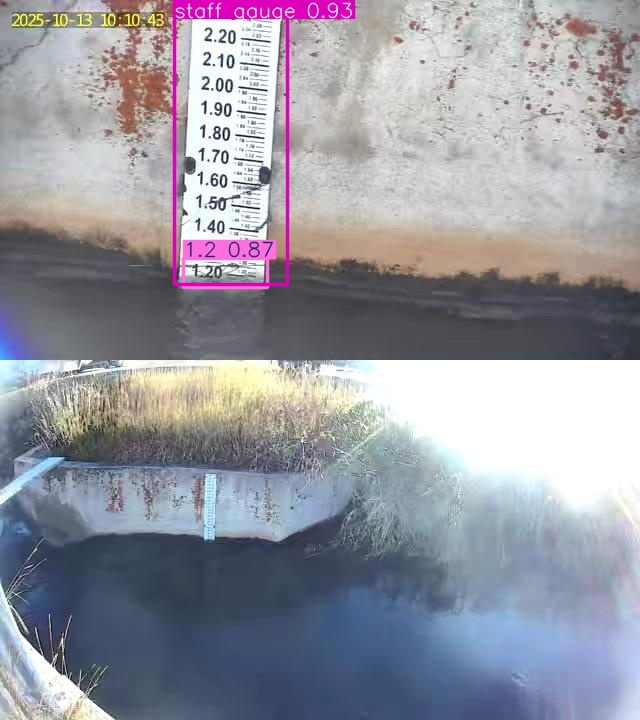

IMG_4065_JPG.rf.ccde114ad2da86436489909b918c5c8b.jpg


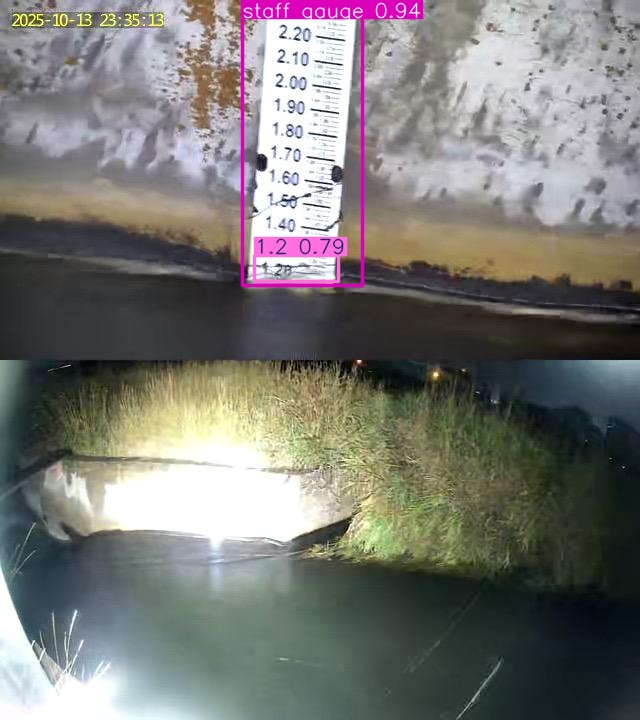

In [ ]:
pred_dir = Path("runs_waterlevel") / "predictions_val_yolov8l"

for name in sorted(os.listdir(pred_dir))[:5]:
    print(name)
    display(Image(filename=str(pred_dir / name)))


In [ ]:
test_folder = root / data_cfg["test"]

results = model_l.predict(
    source=str(test_folder),
    save=True,
    project="runs_waterlevel",
    name="predictions_test_yolov8l",
    conf=0.17,
    imgsz=640
)

print("Saved to:", Path("runs_waterlevel") / "predictions_test_yolov8l")



image 1/24 /content/waterlevel_data/test/images/IMG_4041_JPG.rf.42d646724014f50c64d8105c39b70c4a.jpg: 640x576 1 1.3, 1 staff gauge, 61.0ms
image 2/24 /content/waterlevel_data/test/images/IMG_4045_JPG.rf.00259e9885e8c0b1190270274b29f809.jpg: 640x576 1 1, 1 staff gauge, 61.0ms
image 3/24 /content/waterlevel_data/test/images/IMG_4051_JPG.rf.2165fca543bdaa5c0635106728465d7e.jpg: 640x576 1 1.1, 1 staff gauge, 60.8ms
image 4/24 /content/waterlevel_data/test/images/IMG_4054_JPG.rf.bfa6fe414c8e4f11c7f02347fdbd1f9e.jpg: 640x576 1 2.1, 1 Water Level, 1 staff gauge, 42.0ms
image 5/24 /content/waterlevel_data/test/images/IMG_4059_JPG.rf.5f8cf9126e3328d2178afe6d527e7cbd.jpg: 640x576 1 1.2, 1 staff gauge, 34.6ms
image 6/24 /content/waterlevel_data/test/images/IMG_4060_JPG.rf.ad3c95d1e0c1f82bd6eb5d3c8944ba8b.jpg: 640x576 1 1.2, 1 staff gauge, 35.1ms
image 7/24 /content/waterlevel_data/test/images/IMG_4062_JPG.rf.7e67e7e29f0510bb458a03eeb6f6dfe5.jpg: 640x576 1 1.2, 1 staff gauge, 36.3ms
image 8/24 /c

In [ ]:
class_names = model_l.names
print(class_names)

numeric_class_ids = list(range(0, 10))   # 0..9 are your numeric levels

def predict_water_level(img_path, conf_thresh=0.17):
    """Return highest-confidence numeric level prediction on an image."""
    results = model_l.predict(source=img_path, save=False, conf=conf_thresh)
    best_det = None

    for r in results:
        for box in r.boxes:
            cls_id = int(box.cls[0].item())
            conf = float(box.conf[0].item())
            if cls_id not in numeric_class_ids:
                continue
            if best_det is None or conf > best_det["conf"]:
                best_det = {
                    "cls_id": cls_id,
                    "conf": conf,
                    "box": box.xyxy[0].tolist()
                }

    if best_det is None:
        return None

    level_label = class_names[best_det["cls_id"]]
    return {
        "pred_level": level_label,
        "conf": best_det["conf"],
        "box": best_det["box"],
    }


{0: '0.2', 1: '0.3', 2: '0.4', 3: '1', 4: '1.1', 5: '1.2', 6: '1.3', 7: '1.5', 8: '2.1', 9: '2.3', 10: 'Water Level', 11: 'staff gauge'}


In [ ]:
sample_img = list((root / data_cfg["test"]).iterdir())[0]  # first test image
print("Image:", sample_img)
pred = predict_water_level(str(sample_img))
pred


Image: /content/waterlevel_data/test/images/IMG_4060_JPG.rf.ad3c95d1e0c1f82bd6eb5d3c8944ba8b.jpg

image 1/1 /content/waterlevel_data/test/images/IMG_4060_JPG.rf.ad3c95d1e0c1f82bd6eb5d3c8944ba8b.jpg: 640x576 1 1.2, 1 staff gauge, 60.9ms
Speed: 2.5ms preprocess, 60.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 576)


{'pred_level': '1.2',
 'conf': 0.9480695128440857,
 'box': [180.75816345214844,
  272.57110595703125,
  269.8935546875,
  300.7370910644531]}

In [ ]:
exp_dir_l = Path("runs_waterlevel") / "yolov8l_waterlevel"
best_weights_l = exp_dir_l / "weights" / "best.pt"

assert best_weights_l.exists(), f"best.pt not found at {best_weights_l}"

model_l = YOLO(str(best_weights_l))

test_metrics = model_l.val(
    data=str(DATA_YAML),
    split="test",          # 🔹 use test split from data.yaml
    project="runs_waterlevel",
    name="yolov8l_test"    # results will be in runs_waterlevel/yolov8l_test
)

test_metrics


Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,615,860 parameters, 0 gradients, 164.9 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1315.3±381.7 MB/s, size: 59.9 KB)
val: Scanning /content/waterlevel_data/test/labels.cache... 24 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 24/24 33.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.3it/s 1.6s
                   all         24         72      0.765      0.672      0.729      0.325
                   0.2          3          3      0.933          1      0.995       0.16
                   0.3          3          3          1      0.941      0.995       0.31
                     1          8          8       0.71          1      0.982      0.437
                   1.1          4          4      0.568      0.353      0.845        0.5
                   1.2          4          

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  3,  4,  5,  6,  8, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7883be698410>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046, 

In [ ]:
rd = test_metrics.results_dict
for k, v in rd.items():
    print(f"{k}: {v}")


metrics/precision(B): 0.7654286298287873
metrics/recall(B): 0.6715077203020381
metrics/mAP50(B): 0.7293466140573692
metrics/mAP50-95(B): 0.32518003519493377
fitness: 0.32518003519493377


Files in test results dir: ['BoxF1_curve.png', 'val_batch1_labels.jpg', 'val_batch0_pred.jpg', 'BoxR_curve.png', 'val_batch0_labels.jpg', 'confusion_matrix.png', 'val_batch1_pred.jpg', 'confusion_matrix_normalized.png', 'BoxP_curve.png', 'BoxPR_curve.png']
BoxF1_curve.png


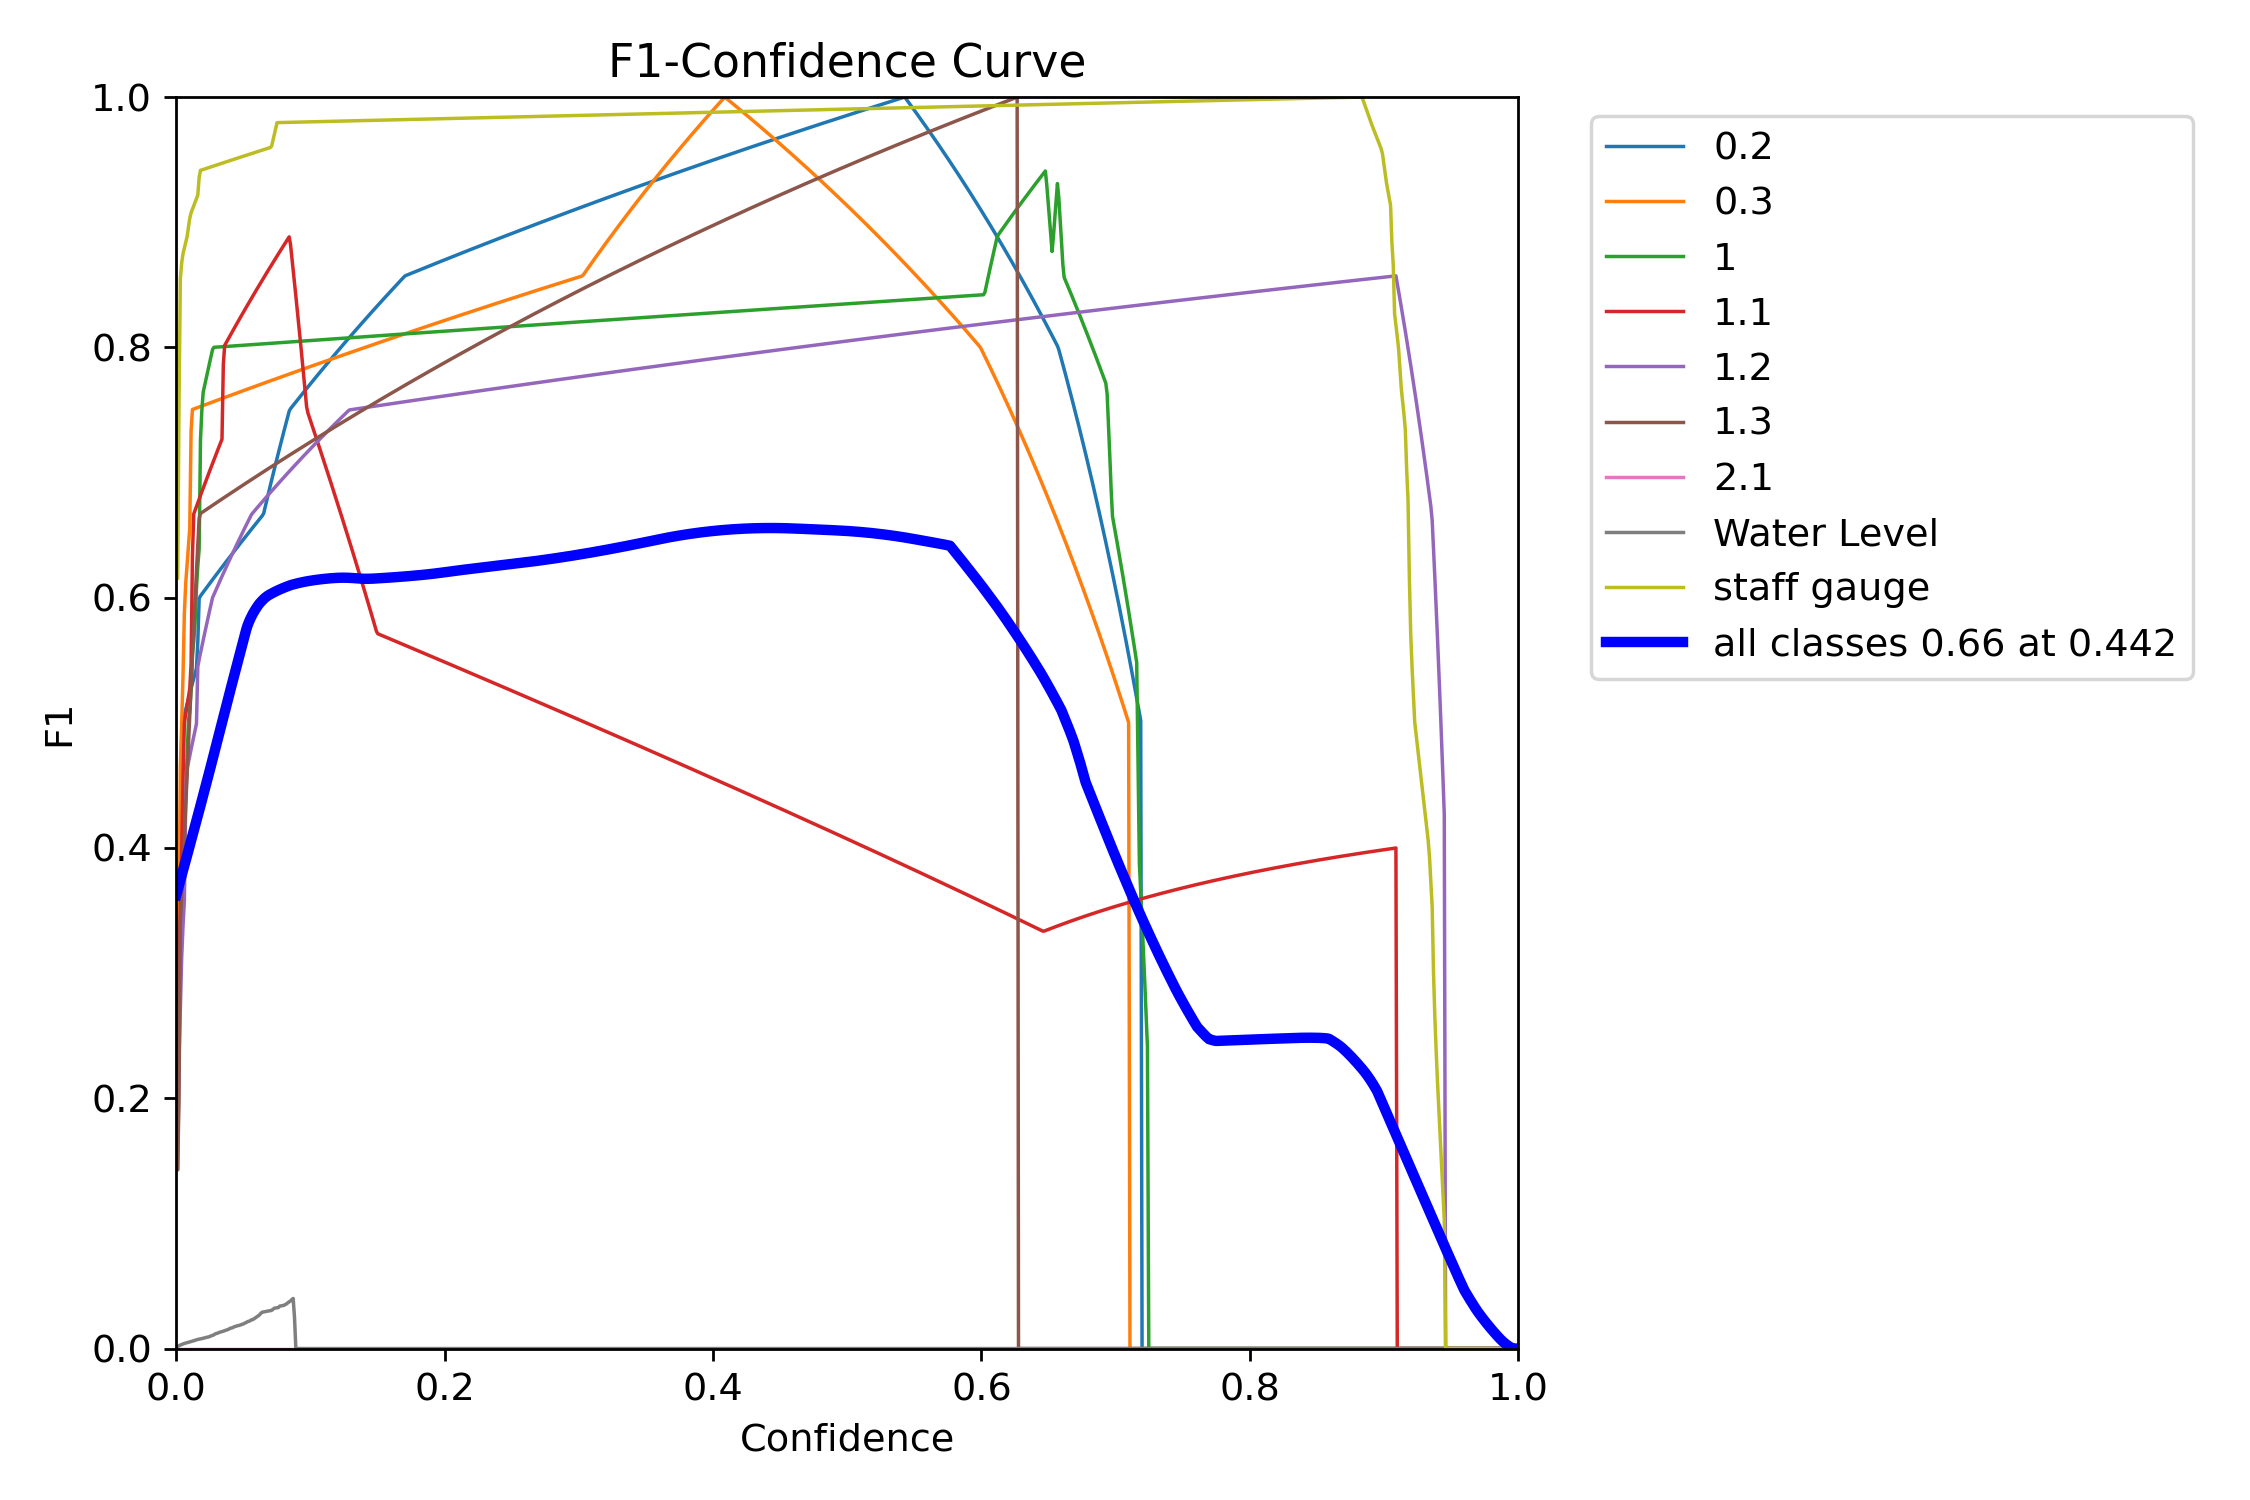

BoxR_curve.png


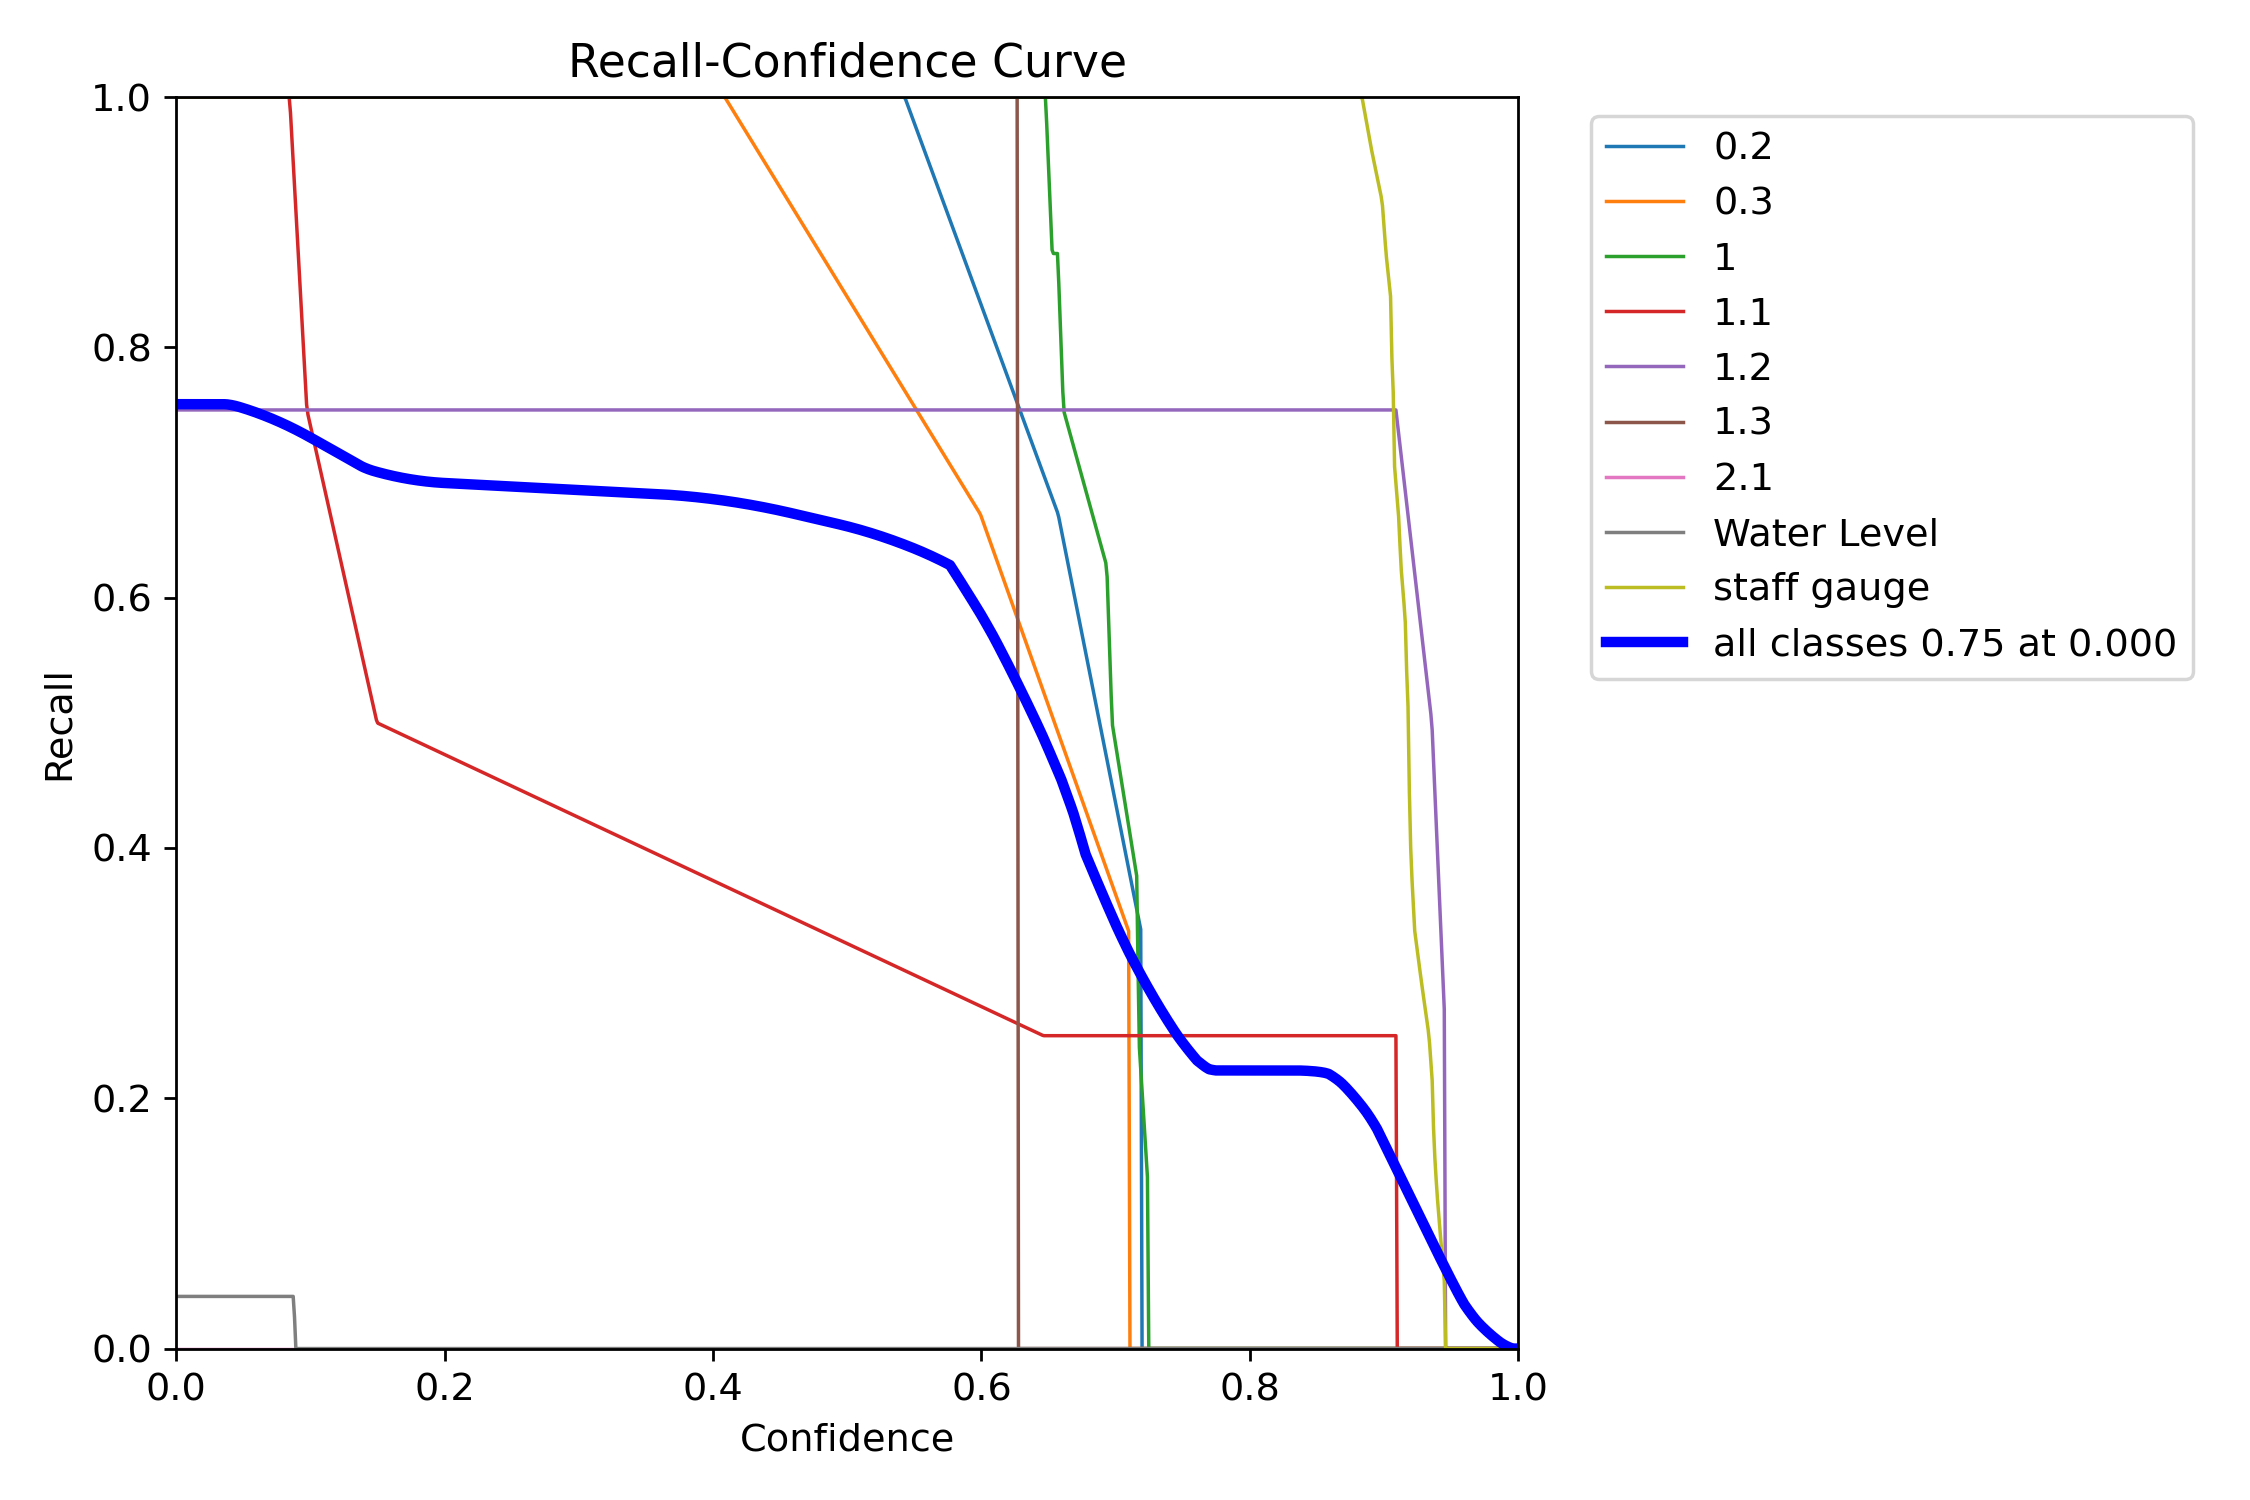

confusion_matrix.png


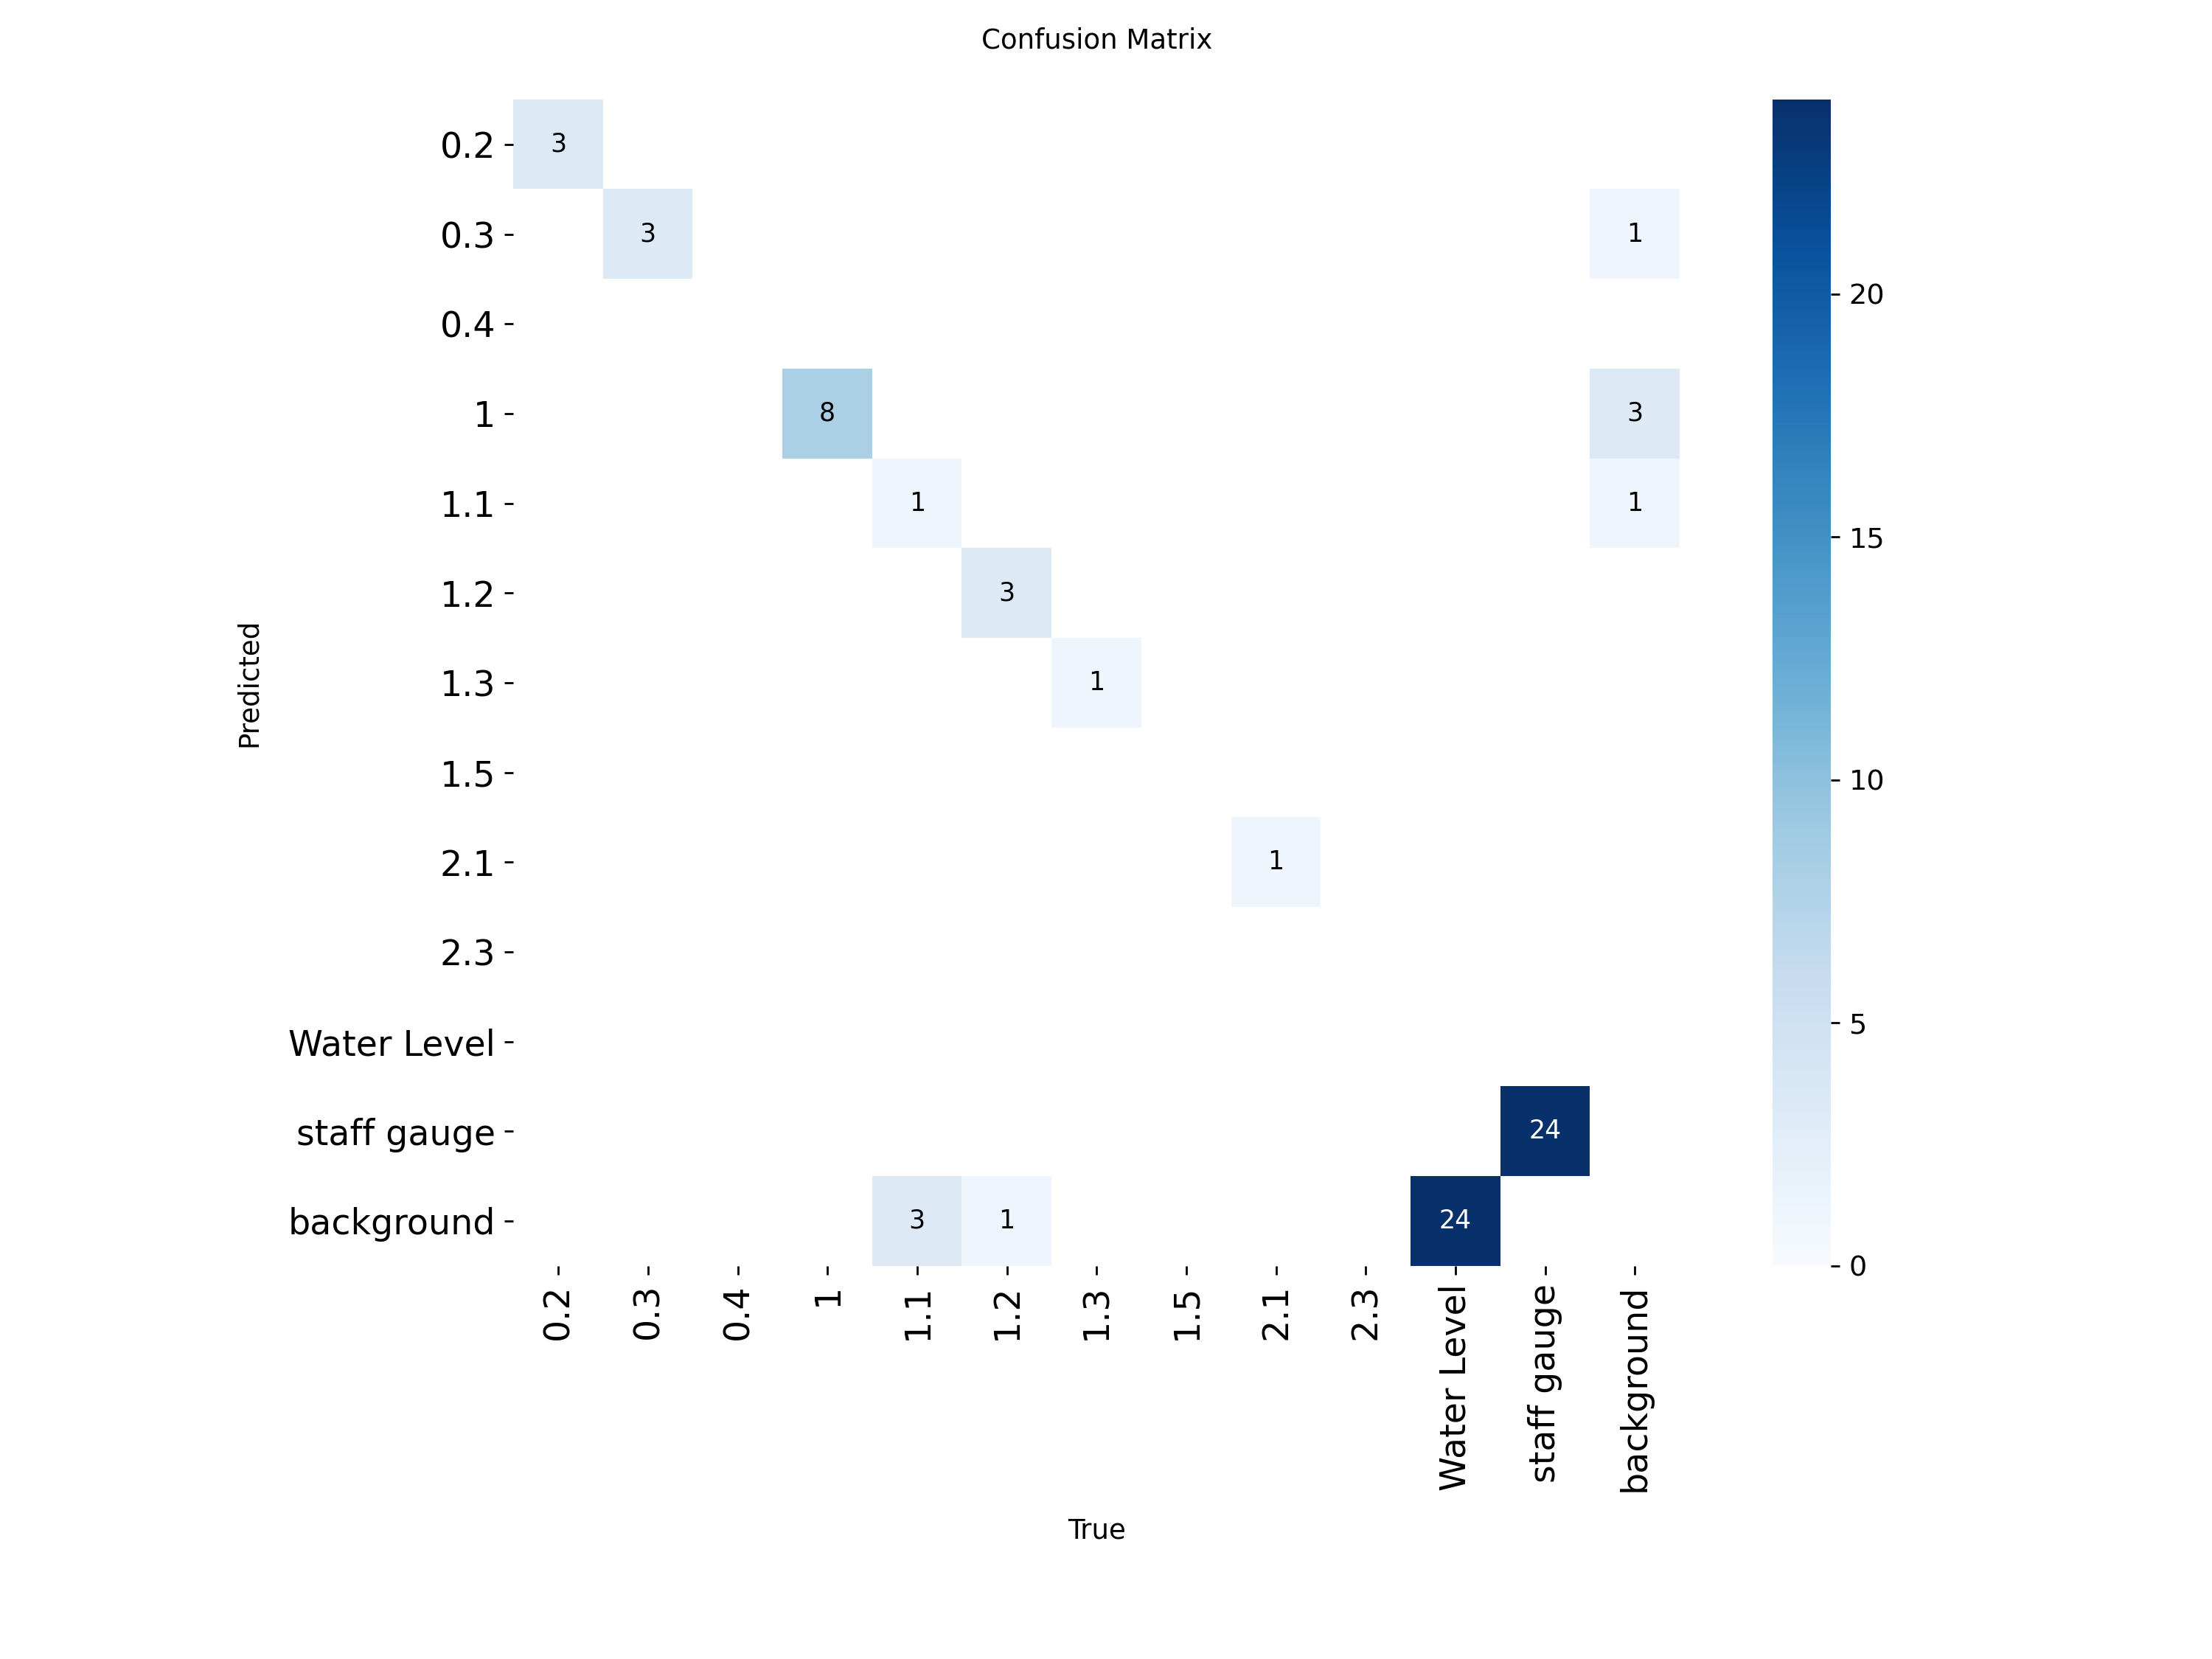

confusion_matrix_normalized.png


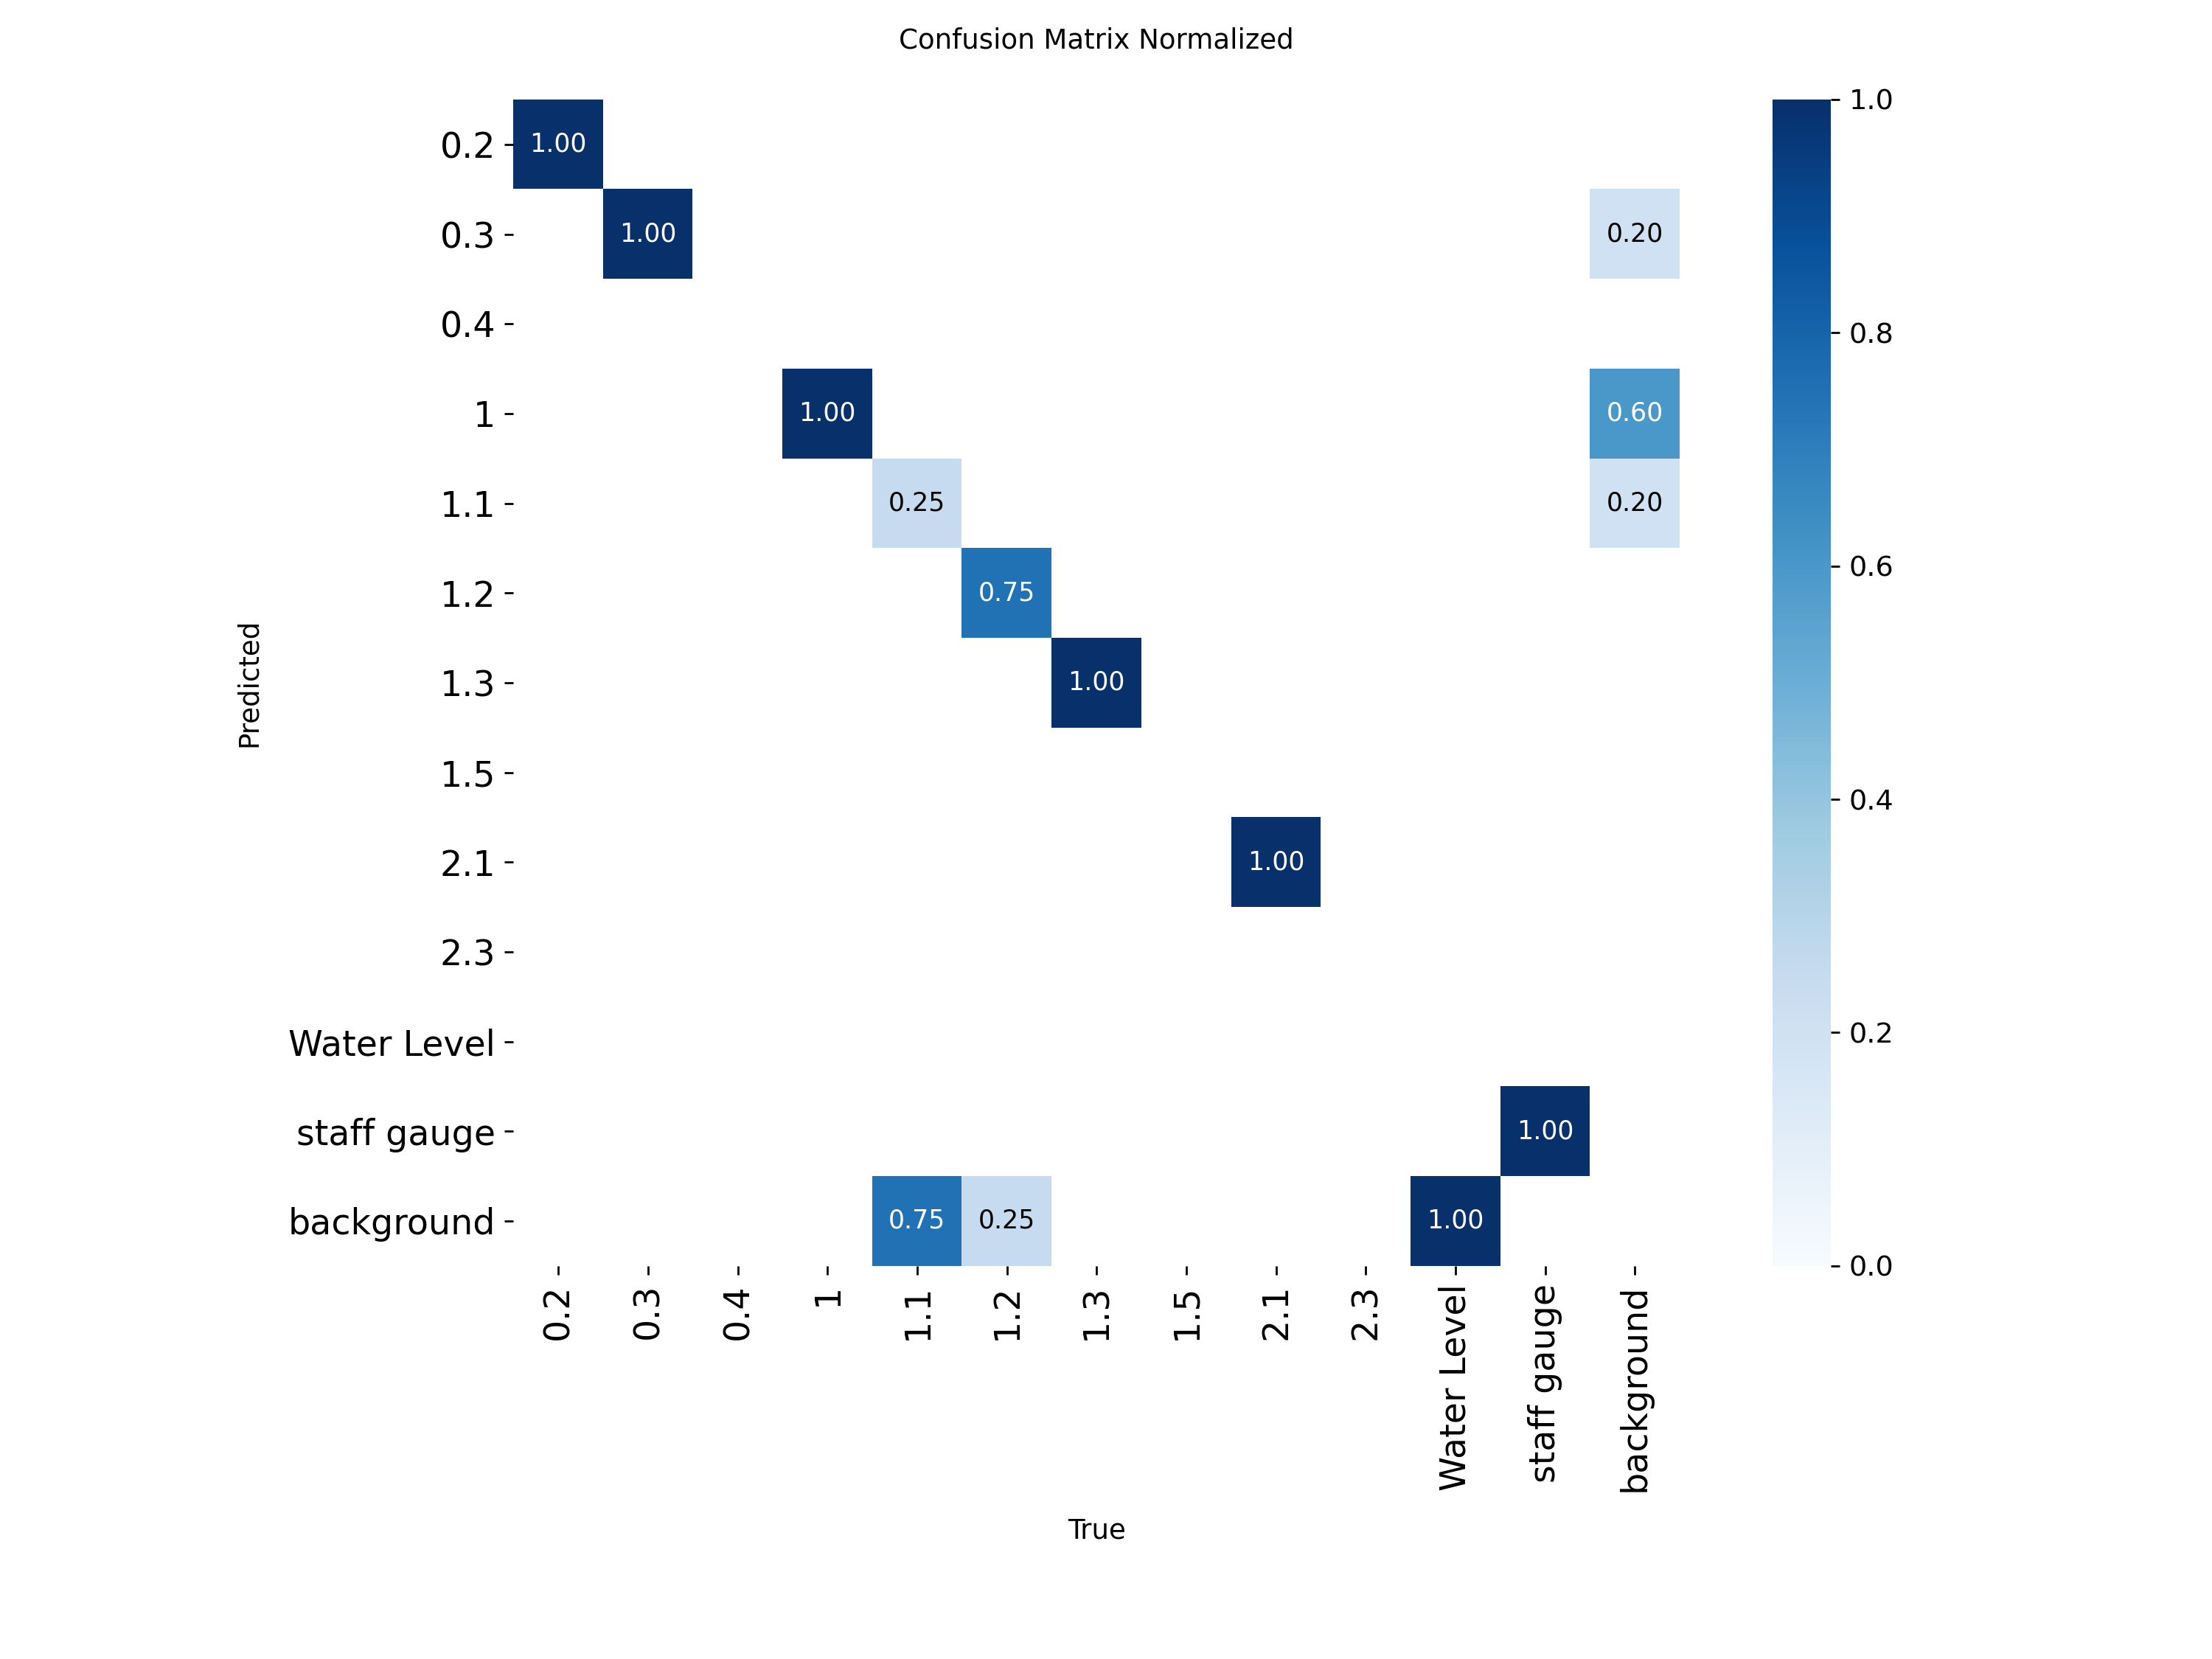

BoxP_curve.png


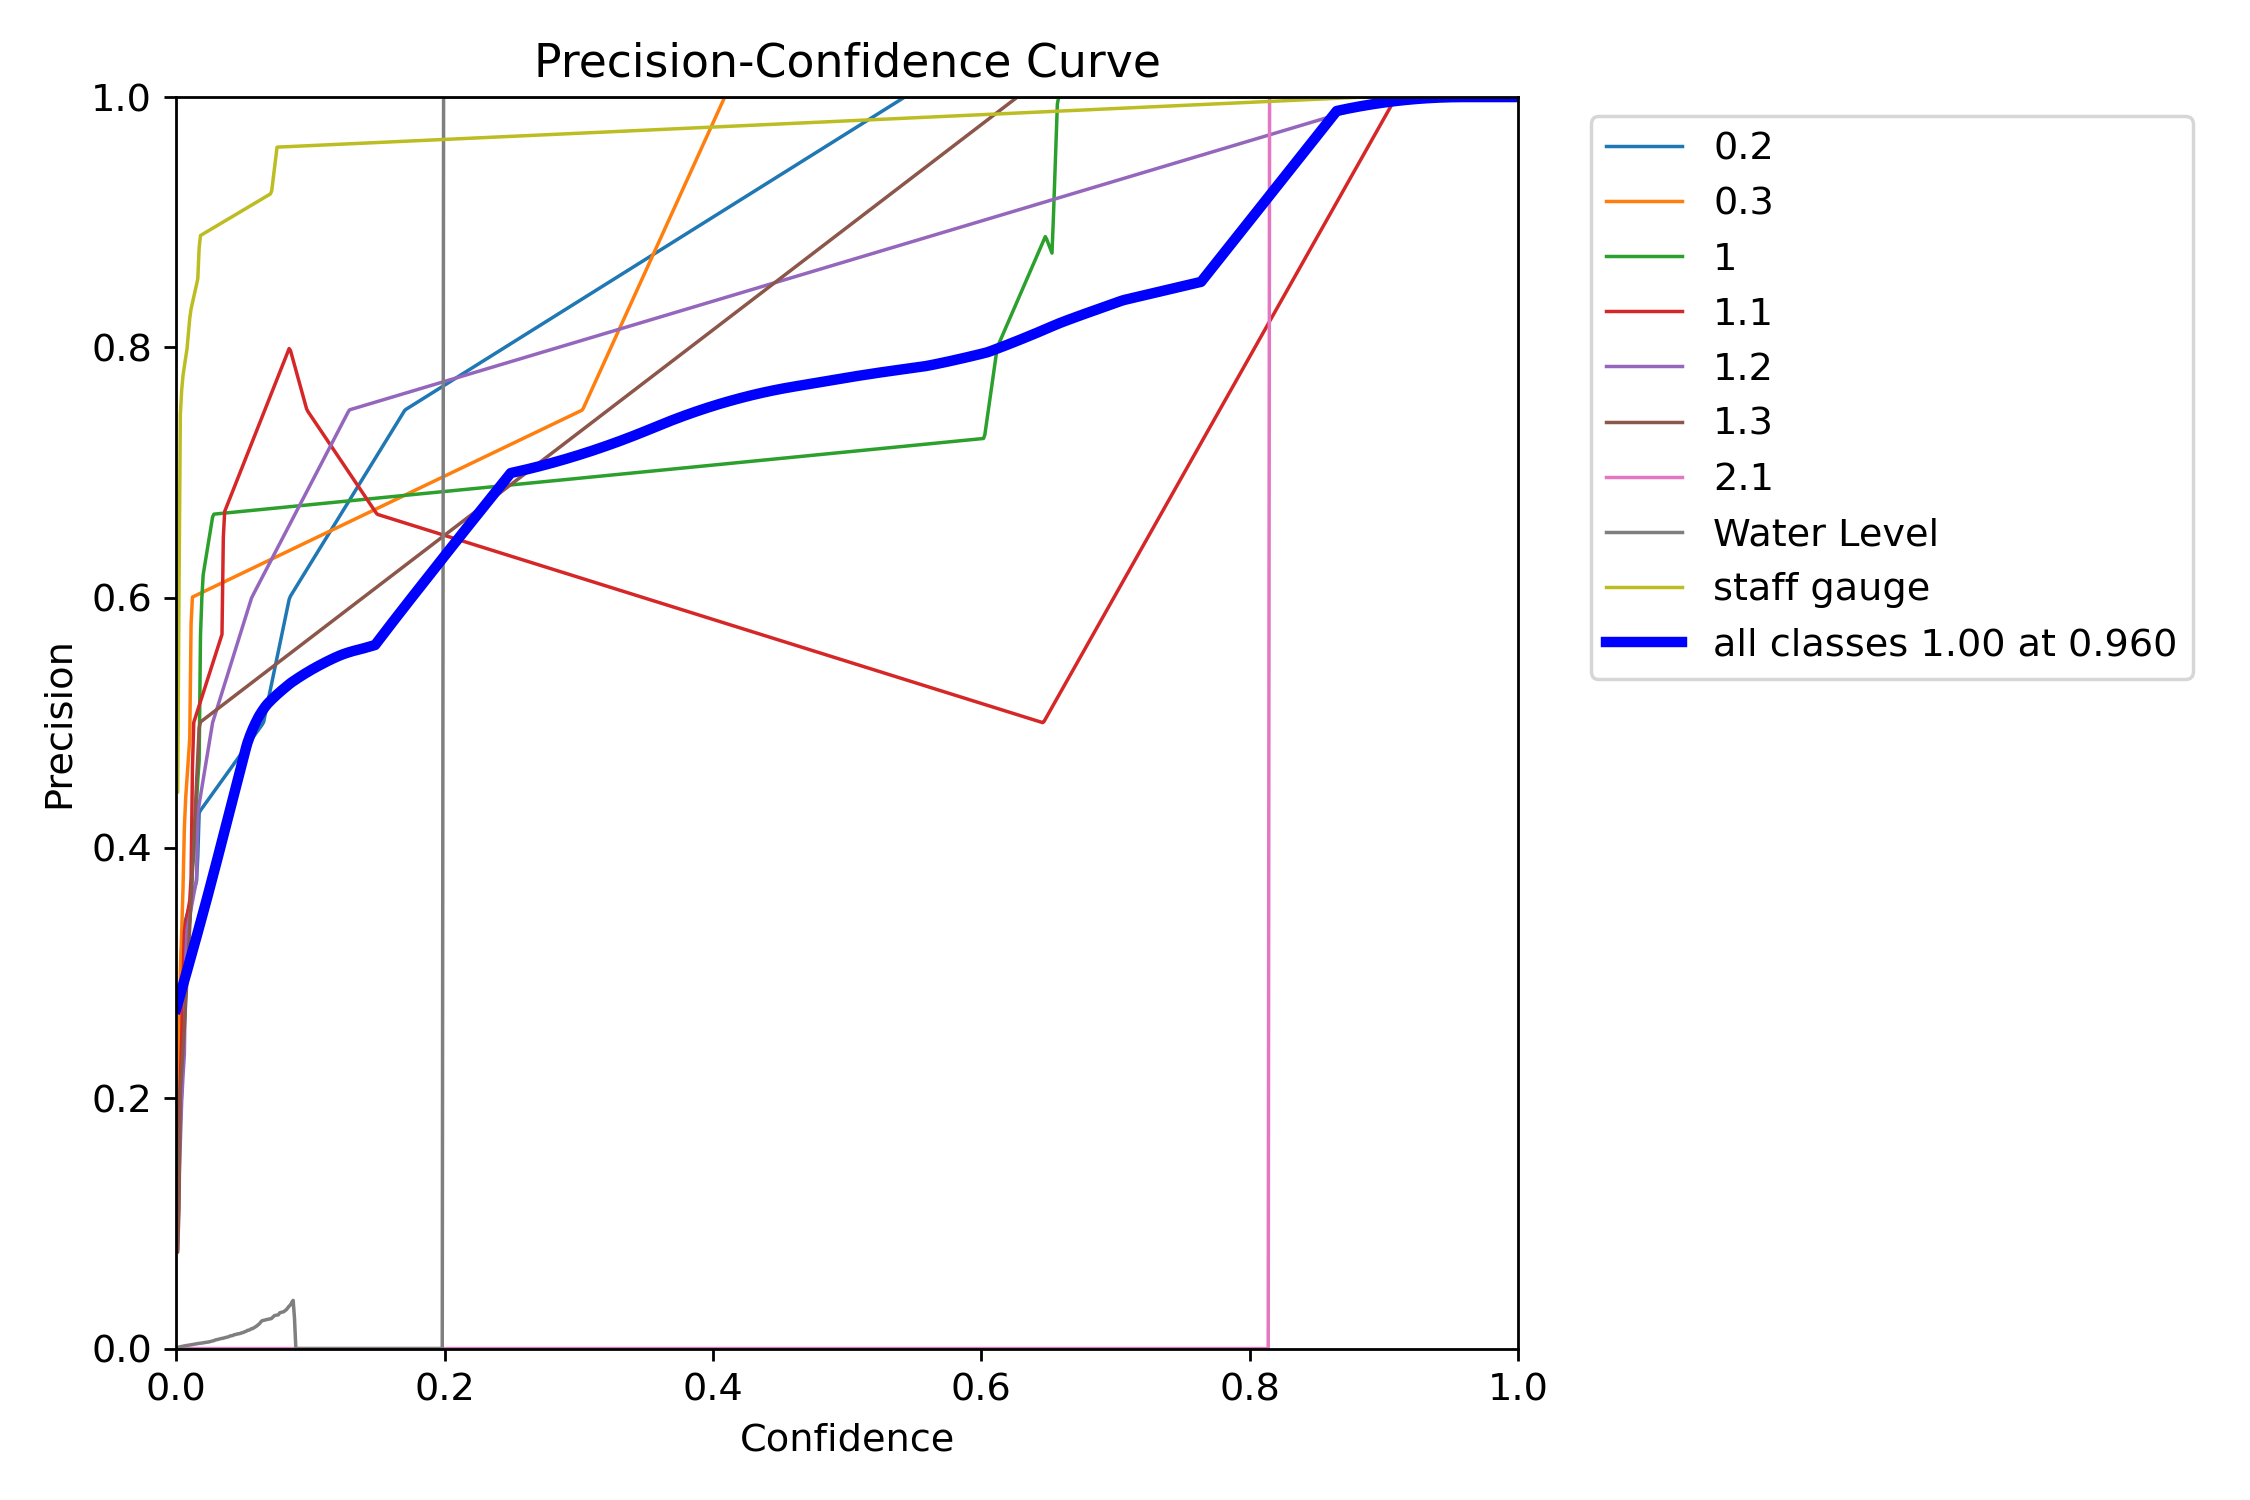

BoxPR_curve.png


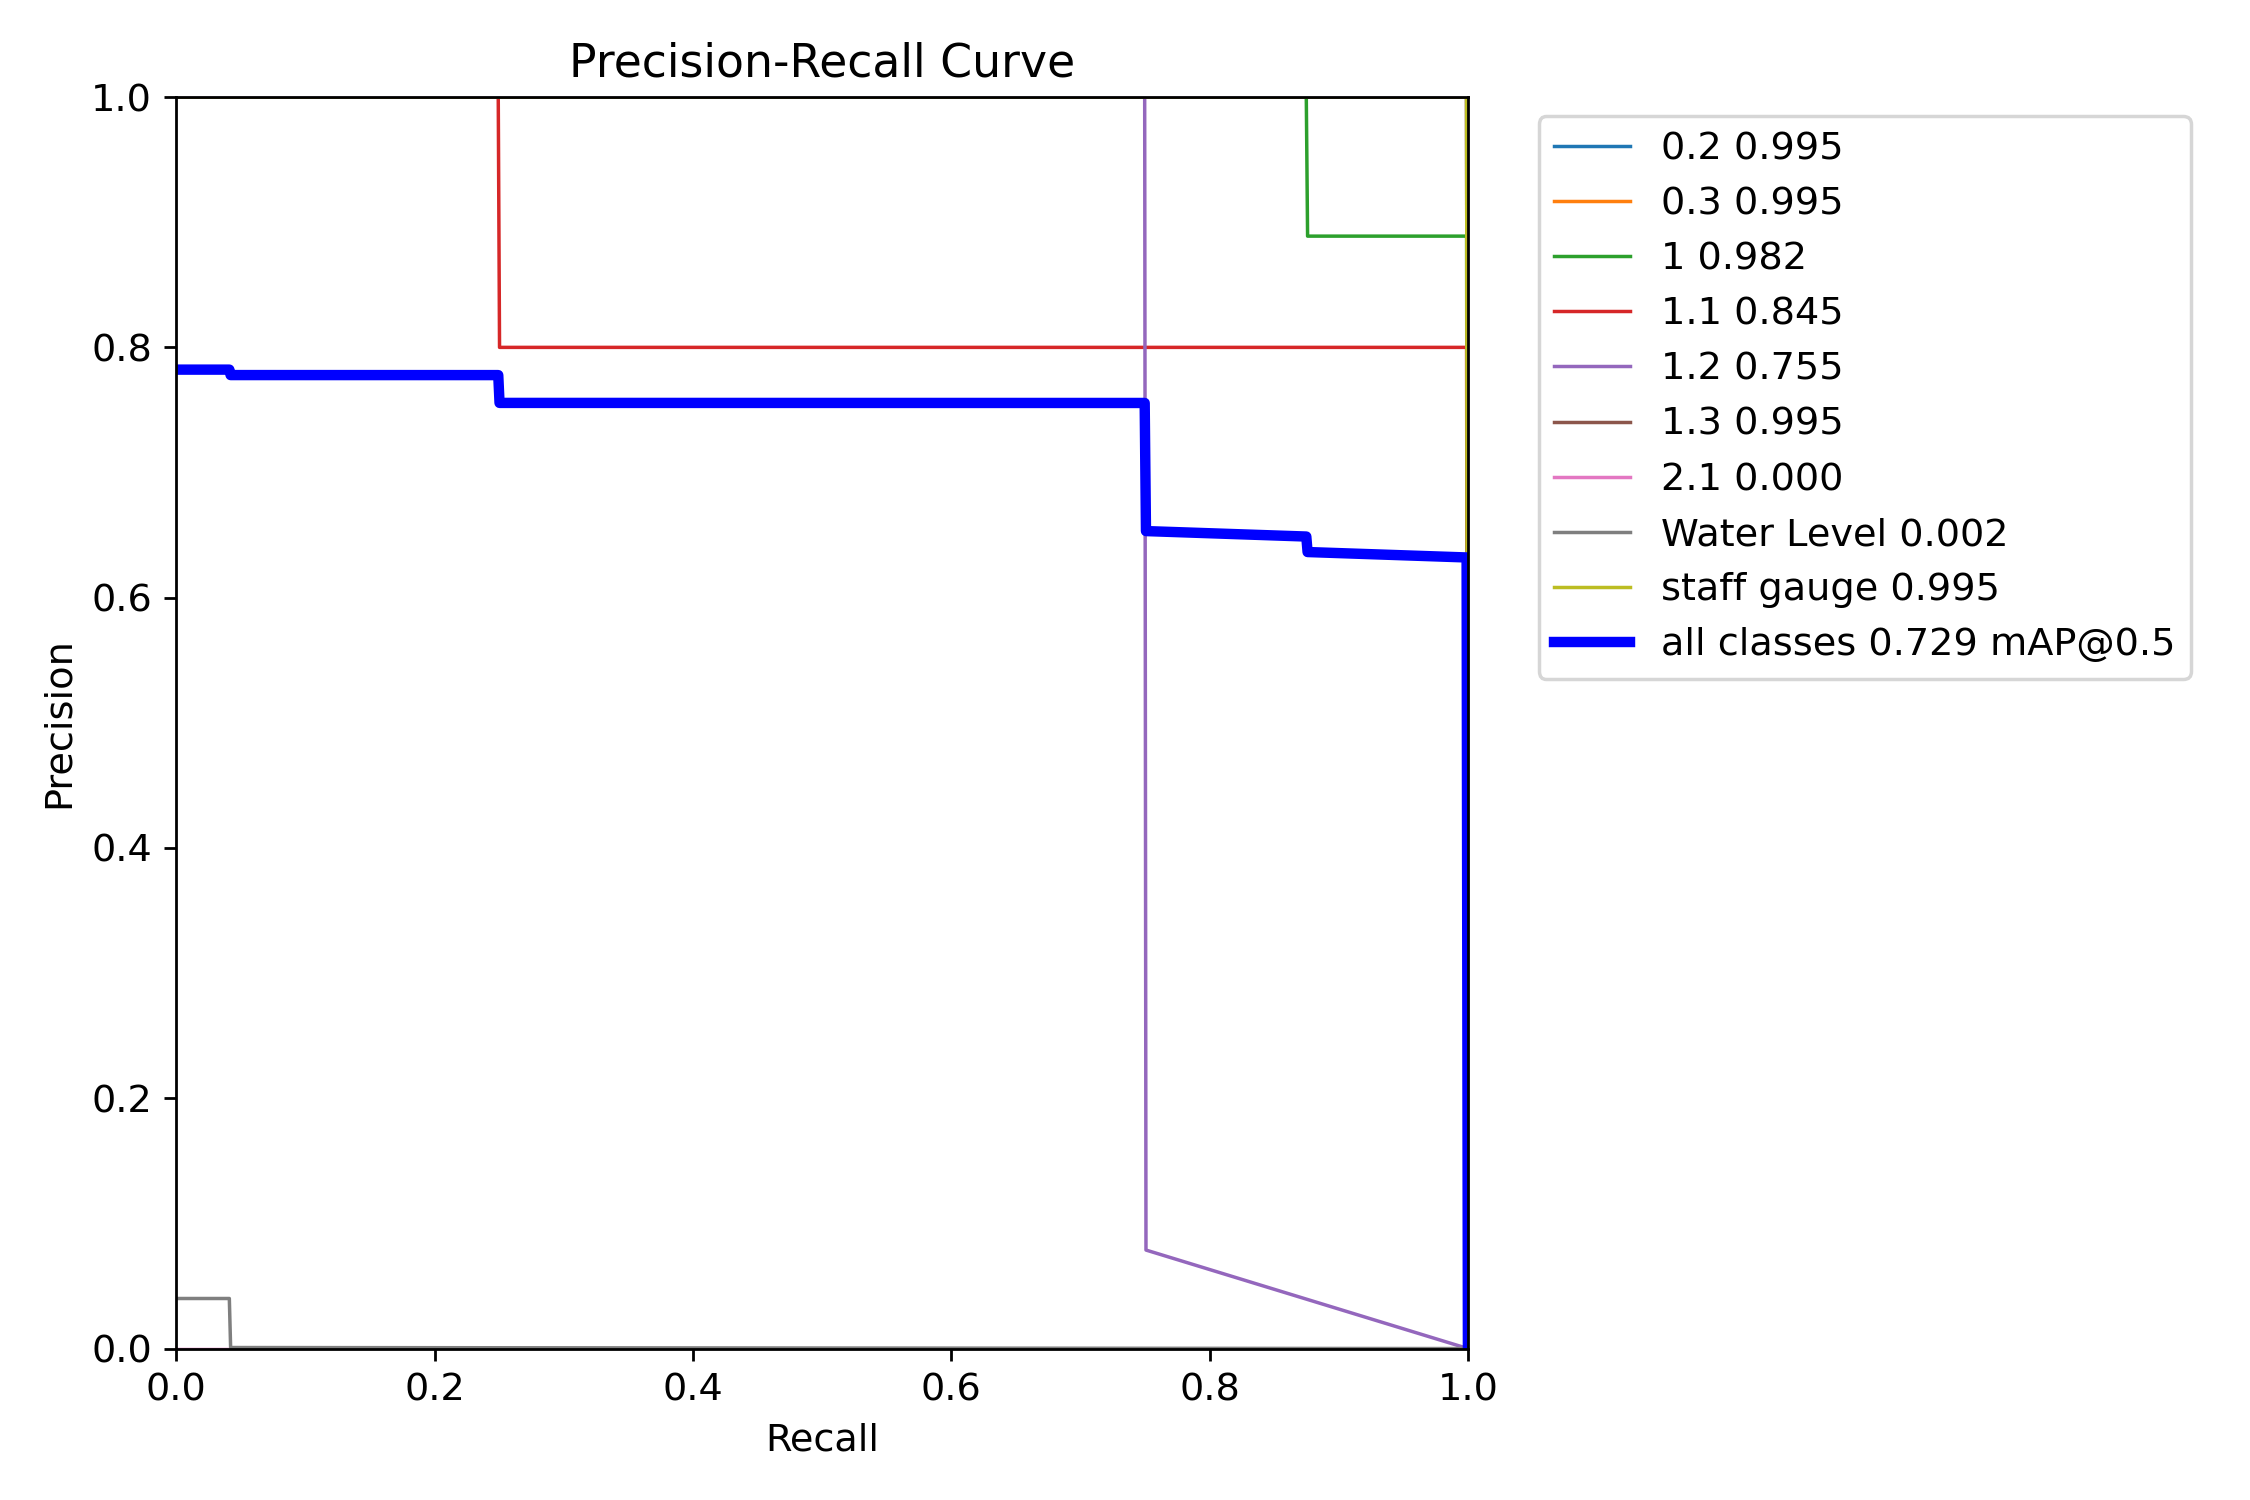

In [ ]:
test_dir = Path("runs_waterlevel") / "yolov8l_test"

print("Files in test results dir:", os.listdir(test_dir))

for fname in os.listdir(test_dir):
    if fname.endswith(".png"):
        print(fname)
        display(Image(filename=str(test_dir / fname)))


In [ ]:
print("Per-class AP50:", test_metrics.box.ap_class_index)
print("Class names:", model_l.names)
print("AP50 per class:", test_metrics.box.ap)   # may need to convert to list


Per-class AP50: [ 0  1  3  4  5  6  8 10 11]
Class names: {0: '0.2', 1: '0.3', 2: '0.4', 3: '1', 4: '1.1', 5: '1.2', 6: '1.3', 7: '1.5', 8: '2.1', 9: '2.3', 10: 'Water Level', 11: 'staff gauge'}
AP50 per class: [     0.1595     0.30973     0.43678     0.49976     0.32044       0.398           0  0.00087588     0.80154]
